In [1]:
import sys
from pathlib import Path
proj_path = Path('.').resolve()
sys.path.append(str(proj_path))

import json
import numpy as np
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.style.use('ggplot')
_ = load_dotenv(find_dotenv())

from src.data_preprocess import (
    load_raw_data,
    process_all_tables,
    load_samples_spider_bird,
)
from run_bo_sql import (remove_duplicate_bos)
from src.eval_utils import (
    SKIP_DB_IDS
)

from collections import defaultdict

/home/simonjisu/code/BusinessObjects/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/simonjisu/code/BusinessObjects/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
# class ARGS():
#     exp_name = 'pipeline_exp' # pipeline_exp , direct_exp
#     ds = 'bird'
#     type = 'test'
    
# args = ARGS()
# description_file = f'description.json' if args.ds == 'spider' else f'{args.ds}_description.json'
# experiment_folder = proj_path / args.exp_name / args.ds
# eval_path = experiment_folder / 'evals'

# description_file = 'bird_description.json' if args.ds == 'bird' else 'description.json'
# tables, *_ = load_raw_data(proj_path / 'data' / args.ds, load_test=False)
# with (proj_path / 'data' / description_file).open() as f:
#     all_descriptions = json.load(f)
# tables = process_all_tables(tables, descriptions=all_descriptions)

# # samples = load_samples_spider_bird(proj_path / 'data' / f'{args.ds}_{args.type}.json')

# Statistics

In [3]:
from collections import Counter

bird_train_samples = load_samples_spider_bird(proj_path / 'data' / f'bird_train.json')
bird_dev_samples = load_samples_spider_bird(proj_path / 'data' / f'bird_dev.json')
bird_test_samples = load_samples_spider_bird(proj_path / 'data' / f'bird_test.json')
with (proj_path / 'pipeline_exp' / 'bird' / 'predictions' / 'fill_in' / 'with_bos-test.json').open() as f:
    bird_test_inference_pipe = json.load(f)
with (proj_path / 'direct_exp' / 'bird' / 'predictions' / 'direct' / 'with_bos-test.json').open() as f:
    bird_test_inference_dirc = json.load(f)

print('BIRD')
a, b, c = len(bird_train_samples), len(bird_dev_samples), len(bird_test_samples)
s = a+b+c
print(f"{a}({a/s*100:.2f}) {b}({b/s*100:.2f}) {c}({c/s*100:.2f})")

spider_train_samples = load_samples_spider_bird(proj_path / 'data' / f'spider_train.json')
spider_dev_samples = load_samples_spider_bird(proj_path / 'data' / f'spider_dev.json')
spider_test_samples = load_samples_spider_bird(proj_path / 'data' / f'spider_test.json')
with (proj_path / 'pipeline_exp' / 'spider' / 'predictions' / 'fill_in' / 'with_bos-test.json').open() as f:
    spider_test_inference_pipe = json.load(f)
with (proj_path / 'direct_exp' / 'spider' / 'predictions' / 'direct' / 'with_bos-test.json').open() as f:
    spider_test_inference_dirc = json.load(f)
print('SPIDER')
a, b, c = len(spider_train_samples), len(spider_dev_samples), len(spider_test_samples)
s = a+b+c
print(f"{a}({a/s*100:.2f}) {b}({b/s*100:.2f}) {c}({c/s*100:.2f})")


BIRD
6341(59.68) 2091(19.68) 2193(20.64)
SPIDER
4760(59.37) 1555(19.40) 1702(21.23)


In [4]:
def count_bos(bos):
    cnt_bos = []
    db_ids = []
    bos_complexities = defaultdict(list)
    for db_id in bos:
        if db_id in SKIP_DB_IDS:
            continue
        cnt_bos.append(len(bos[db_id]))
        db_ids.append(db_id)
        bos_complexities[db_id] = [(bo['sample_id'], bo['gold_complexity']) for bo in bos[db_id]]
    return db_ids, np.array(cnt_bos), bos_complexities

def count_samples(ds, type):
    samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_{type}.json')
    samples = [s for s in samples if s.db_id not in SKIP_DB_IDS]
    samples_by_db = []
    for db_id in set([s.db_id for s in samples]):
        samples_by_db.append(len([s for s in samples if s.db_id == db_id]))
    return np.array(samples_by_db)

def get_bos(exp_name: str, typ: str):
    spider_bo_path = proj_path / exp_name / 'spider' / 'predictions' / 'create_bo' / f'final_spider_{typ}_bo.json'
    with spider_bo_path.open() as f:
        spider_bos = remove_duplicate_bos(json.load(f))
    spider_db_ids, spider_bos_cnts, spider_bos_com = count_bos(spider_bos)

    bird_bo_path = proj_path / exp_name / 'bird' / 'predictions' / 'create_bo' / f'final_bird_{typ}_bo.json'
    with bird_bo_path.open() as f:
        bird_bos = remove_duplicate_bos(json.load(f))
    bird_db_ids, bird_bos_cnts, bird_bos_com = count_bos(bird_bos)

    print(f'{typ.capitalize()} BOs')
    print(f'Spider({len(spider_bos_cnts)}): total={sum(spider_bos_cnts)} avg_per_db={spider_bos_cnts.mean():.2f} +/- {spider_bos_cnts.std():.2f} min-max=({spider_bos_cnts.min()}, {spider_bos_cnts.max()})')
    print(f'Bird({len(bird_bos_cnts)}): total={sum(bird_bos_cnts)} avg_per_db={bird_bos_cnts.mean():.2f} +/- {bird_bos_cnts.std():.2f} min-max=({bird_bos_cnts.min()}, {bird_bos_cnts.max()})')

    spider_bos_cnts = {db_id: cnt for db_id, cnt in zip(spider_db_ids, spider_bos_cnts)}
    bird_bos_cnts = {db_id: cnt for db_id, cnt in zip(bird_db_ids, bird_bos_cnts)}
    return spider_bos_cnts, spider_bos_com, bird_bos_cnts, bird_bos_com

print('Train BOs (Candidate)')
# average numbers of bos for each database
get_bos('direct_exp', 'train')
get_bos('pipeline_exp', 'train')

print('== Direct Inference ==')
spider_dirc_bos_cnts, spider_dirc_bos_com, bird_dirc_bos_cnts, bird_dirc_bos_com = \
    get_bos('direct_exp', 'test')

print('== Pipeline Inference ==')
spider_pipe_bos_cnts, spider_pipe_bos_com, bird_pipe_bos_cnts, bird_pipe_bos_com = \
    get_bos('pipeline_exp', 'test')

print('\n# of queries to validate BOs')
spider_dev = count_samples('spider', 'dev')
print(f'Spider({len(spider_dev)}): total={sum(spider_dev)} avg_per_db={spider_dev.mean():.2f} +/- {spider_dev.std():.2f} min-max=({spider_dev.min()}, {spider_dev.max()})')
bird_dev = count_samples('bird', 'dev')
print(f'Bird({len(bird_dev)}): total={sum(bird_dev)} avg_per_db={bird_dev.mean():.2f} +/- {bird_dev.std():.2f} min-max=({bird_dev.min()}, {bird_dev.max()})')

Train BOs (Candidate)
Train BOs
Spider(158): total=3502 avg_per_db=22.16 +/- 12.17 min-max=(8, 71)
Bird(78): total=5998 avg_per_db=76.90 +/- 44.94 min-max=(11, 279)
Train BOs
Spider(158): total=3502 avg_per_db=22.16 +/- 12.17 min-max=(8, 71)
Bird(78): total=5998 avg_per_db=76.90 +/- 44.94 min-max=(11, 279)
== Direct Inference ==
Test BOs
Spider(157): total=1200 avg_per_db=7.64 +/- 5.47 min-max=(1, 25)
Bird(78): total=1602 avg_per_db=20.54 +/- 7.33 min-max=(3, 25)
== Pipeline Inference ==
Test BOs
Spider(157): total=1200 avg_per_db=7.64 +/- 5.47 min-max=(1, 25)
Bird(78): total=1602 avg_per_db=20.54 +/- 7.33 min-max=(3, 25)

# of queries to validate BOs
Spider(158): total=1555 avg_per_db=9.84 +/- 6.22 min-max=(2, 34)
Bird(78): total=2058 avg_per_db=26.38 +/- 15.54 min-max=(3, 93)


In [5]:
import numpy as np
from scipy.optimize import linear_sum_assignment 

score_matrix = np.random.rand(5, 5) 

row_ind, col_ind = linear_sum_assignment(score_matrix, maximize=True)
row_ind, col_ind
(score_matrix[row_ind, col_ind] + 1-9).mean()

-7.260418091843249

In [6]:
spider_pipe = pd.read_csv(proj_path / 'pipeline_exp' / 'spider' / 'evals' / f'pipeline_exp.csv')
spider_dirc = pd.read_csv(proj_path / 'direct_exp' / 'spider' / 'evals' / f'direct_exp.csv')

bird_pipe = pd.read_csv(proj_path / 'pipeline_exp' / 'bird' / 'evals' / f'pipeline_exp.csv')
bird_dirc = pd.read_csv(proj_path / 'direct_exp' / 'bird' / 'evals' / f'direct_exp.csv')

left = np.setdiff1d(spider_dirc['sample_id'].unique(), spider_pipe['sample_id'].unique())
right = np.setdiff1d(spider_pipe['sample_id'].unique(), spider_dirc['sample_id'].unique())
spider_drop_ids = set(left).union(set(right))

left = np.setdiff1d(bird_dirc['sample_id'].unique(), bird_pipe['sample_id'].unique())
right = np.setdiff1d(bird_pipe['sample_id'].unique(), bird_dirc['sample_id'].unique())
bird_drop_ids = set(left).union(set(right))

spider_pipe = spider_pipe[~spider_pipe['sample_id'].isin(spider_drop_ids)]
spider_dirc = spider_dirc[~spider_dirc['sample_id'].isin(spider_drop_ids)]

bird_pipe = bird_pipe[~bird_pipe['sample_id'].isin(bird_drop_ids)]
bird_dirc = bird_dirc[~bird_dirc['sample_id'].isin(bird_drop_ids)]

# group by db_id and get the mean of each db_id
spider_summ_pipe = spider_pipe.groupby('db_id')['sample_id'].size().describe()
spider_summ_dirc = spider_dirc.groupby('db_id')['sample_id'].size().describe()

bird_summ_pipe = bird_pipe.groupby('db_id')['sample_id'].size().describe()
bird_summ_dirc = bird_dirc.groupby('db_id')['sample_id'].size().describe()

print('# of test Queries per database')
print(f'Spider | total={len(spider_pipe)} avg_per_db={spider_summ_pipe["mean"]:.2f}')
print(f'Bird | total={len(bird_pipe)} avg_per_db={bird_summ_pipe["mean"]:.2f}')

# of test Queries per database
Spider | total=1699 avg_per_db=10.75
Bird | total=2019 avg_per_db=25.88


In [7]:
spider_cates = spider_dirc['cates'].unique().tolist()
bird_cates = bird_dirc['cates'].unique().tolist()

def get_complexity_category(cates, cate):
    if cate == None:
        return None
    cates_num = [tuple(map(lambda x: int(x.strip()), c.split('-'))) for c in cates]
    for i, (c1, c2) in enumerate(cates_num):
        if c1 <= cate < c2:
            return cates[i]
    
    return None

spider_dirc['num_bos'] = spider_dirc['db_id'].apply(lambda x: spider_dirc_bos_cnts.get(x, 0))
spider_dirc['num_bos'] = spider_dirc['num_bos'].astype(int)
spider_dirc['bo_complexity'] = None 
for db_id, sample_complexities in spider_dirc_bos_com.items():
    for bo_id, complexity in sample_complexities:
        spider_dirc.loc[(spider_dirc['db_id'] == db_id) & (spider_dirc['retrieved'] == bo_id), 'bo_complexity'] = complexity
# spider_dirc.loc[spider_dirc['bo_complexity'].isnull(), 'bo_complexity'] = -1
spider_dirc['bo_cates'] = spider_dirc['bo_complexity'].apply(lambda x: get_complexity_category(spider_cates, x))

spider_pipe['num_bos'] = spider_pipe['db_id'].apply(lambda x: spider_pipe_bos_cnts.get(x, 0))
spider_pipe['num_bos'] = spider_pipe['num_bos'].astype(int)
spider_pipe['bo_complexity'] = None
for db_id, sample_complexities in spider_pipe_bos_com.items():
    for bo_id, complexity in sample_complexities:
        spider_pipe.loc[(spider_pipe['db_id'] == db_id) & (spider_pipe['retrieved'] == bo_id), 'bo_complexity'] = complexity
# spider_pipe.loc[spider_pipe['bo_complexity'].isnull(), 'bo_complexity'] = -1
spider_pipe['bo_cates'] = spider_pipe['bo_complexity'].apply(lambda x: get_complexity_category(spider_cates, x))

bird_dirc['num_bos'] = bird_dirc['db_id'].apply(lambda x: bird_dirc_bos_cnts.get(x, 0))
bird_dirc['num_bos'] = bird_dirc['num_bos'].astype(int)
bird_dirc['bo_complexity'] = None
for db_id, sample_complexities in bird_dirc_bos_com.items():
    for bo_id, complexity in sample_complexities:
        bird_dirc.loc[(bird_dirc['db_id'] == db_id) & (bird_dirc['retrieved'] == bo_id), 'bo_complexity'] = complexity
# bird_dirc.loc[bird_dirc['bo_complexity'].isnull(), 'bo_complexity'] = -1
bird_dirc['bo_cates'] = bird_dirc['bo_complexity'].apply(lambda x: get_complexity_category(bird_cates, x))

bird_pipe['num_bos'] = bird_pipe['db_id'].apply(lambda x: bird_pipe_bos_cnts.get(x, 0))
bird_pipe['num_bos'] = bird_pipe['num_bos'].astype(int)
bird_pipe['bo_complexity'] = None
for db_id, sample_complexities in bird_pipe_bos_com.items():
    for bo_id, complexity in sample_complexities:
        bird_pipe.loc[(bird_pipe['db_id'] == db_id) & (bird_pipe['retrieved'] == bo_id), 'bo_complexity'] = complexity
# bird_pipe.loc[bird_pipe['bo_complexity'].isnull(), 'bo_complexity'] = -1
bird_pipe['bo_cates'] = bird_pipe['bo_complexity'].apply(lambda x: get_complexity_category(bird_cates, x))

In [8]:
# experiment old: 
spider_bo_0 = pd.read_csv(proj_path / 'experiments_old' / 'spider' / 'evals' / 'zero_shot_hint' / 'spider_test_0.csv').rename(columns={'exec_result': 'exec_res'})
spider_bo_1 = pd.read_csv(proj_path / 'experiments_old' / 'spider' / 'evals' / 'zero_shot_hint' / 'spider_test_1.csv').rename(columns={'exec_result': 'exec_res'}) 
spider_bo = pd.read_csv(proj_path / 'experiments_old' / 'spider' / 'evals' / 'zero_shot_hint' / 'spider_test_2.csv').rename(columns={'exec_result': 'exec_res'})
spider_bo_q = pd.read_csv(proj_path / 'experiments_old' / 'spider' / 'evals' / 'zero_shot_hint' / 'spider_test_3.csv').rename(columns={'exec_result': 'exec_res'})
spider_base = pd.read_csv(proj_path / 'experiments_old' / 'spider' / 'evals' / 'zero_shot' / 'spider_test.csv').rename(columns={'exec_result': 'exec_res'})

unique_sample_ids = set(spider_bo['sample_id'].unique()).union(set(spider_bo_q['sample_id'].unique())).union(set(spider_base['sample_id'].unique()))
spider_bo = spider_bo[spider_bo['sample_id'].isin(unique_sample_ids)]
spider_bo_q = spider_bo_q[spider_bo_q['sample_id'].isin(unique_sample_ids)]
spider_base = spider_base[spider_base['sample_id'].isin(unique_sample_ids)]

spider_bo_0 = pd.merge(left=spider_bo_0, right=spider_base, how='inner', on=['db_id', 'sample_id'], suffixes=('_bo', ''))
spider_bo_1 = pd.merge(left=spider_bo_1, right=spider_base, how='inner', on=['db_id', 'sample_id'], suffixes=('_bo', ''))
spider_bo = pd.merge(left=spider_bo, right=spider_base, how='inner', on=['db_id', 'sample_id'], suffixes=('_bo', ''))
spider_bo_q = pd.merge(left=spider_bo_q, right=spider_base, how='inner', on=['db_id', 'sample_id'], suffixes=('_bo', ''))

bird_bo_0 = pd.read_csv(proj_path / 'experiments_old' / 'bird' / 'evals' / 'zero_shot_hint' / 'bird_test_0.csv').rename(columns={'exec_result': 'exec_res'})
bird_bo_1 = pd.read_csv(proj_path / 'experiments_old' / 'bird' / 'evals' / 'zero_shot_hint' / 'bird_test_1.csv').rename(columns={'exec_result': 'exec_res'})
bird_bo = pd.read_csv(proj_path / 'experiments_old' / 'bird' / 'evals' / 'zero_shot_hint' / 'bird_test_2.csv').rename(columns={'exec_result': 'exec_res'})
bird_bo_q = pd.read_csv(proj_path / 'experiments_old' / 'bird' / 'evals' / 'zero_shot_hint' / 'bird_test_3.csv').rename(columns={'exec_result': 'exec_res'})
bird_base = pd.read_csv(proj_path / 'experiments_old' / 'bird' / 'evals' / 'zero_shot' / 'bird_test.csv').rename(columns={'exec_result': 'exec_res'})

unique_sample_ids = set(bird_bo['sample_id'].unique()).union(set(bird_bo_q['sample_id'].unique())).union(set(bird_base['sample_id'].unique()))
bird_bo = bird_bo[bird_bo['sample_id'].isin(unique_sample_ids)]
bird_bo_q = bird_bo_q[bird_bo_q['sample_id'].isin(unique_sample_ids)]
bird_base = bird_base[bird_base['sample_id'].isin(unique_sample_ids)]

bird_bo_0 = pd.merge(left=bird_bo_0, right=bird_base, how='inner', on=['db_id', 'sample_id'], suffixes=('_bo', ''))
bird_bo_1 = pd.merge(left=bird_bo_1, right=bird_base, how='inner', on=['db_id', 'sample_id'], suffixes=('_bo', ''))
bird_bo = pd.merge( left=bird_bo, right=bird_base, how='inner', on=['db_id', 'sample_id'], suffixes=('_bo', ''))
bird_bo_q = pd.merge(left=bird_bo_q, right=bird_base, how='inner', on=['db_id', 'sample_id'], suffixes=('_bo', ''))


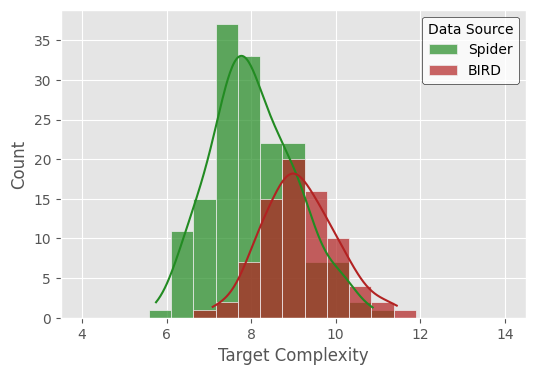

In [9]:
def plot_target_complexity_dist(df_spider: pd.DataFrame, df_bird: pd.DataFrame, clip_val: int):
    df_spider = df_spider.copy()
    df_bird = df_bird.copy()
    df_spider.loc[df_spider['target_complexity'] >= clip_val, 'target_complexity'] = clip_val
    df_bird.loc[df_bird['target_complexity'] >= clip_val, 'target_complexity'] = clip_val
    
    spider_min, spider_max = df_spider['target_complexity'].min(), df_spider['target_complexity'].max()
    bird_min, bird_max = df_bird['target_complexity'].min(), df_bird['target_complexity'].max()

    min_val = min(spider_min, bird_min)
    max_val = max_val = max(spider_max, bird_max)
    
    bins = np.linspace(min_val, max_val, 20)
    spider_group = df_spider.groupby('db_id')['target_complexity'].mean()
    bird_group = df_bird.groupby('db_id')['target_complexity'].mean()
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.histplot(spider_group, bins=bins, kde=True, ax=ax, label='Spider', alpha=0.7, color='forestgreen')
    sns.histplot(bird_group, bins=bins, kde=True, ax=ax, label='BIRD', alpha=0.7, color='firebrick')
    # ax.set_title('Average Target Complexity Per DB Distribution')
    ax.set_xlabel('Target Complexity')
    ax.set_ylabel('Count')
    ax.legend(title='Data Source', frameon=True, facecolor='white', edgecolor='black', loc='upper right')
    plt.show()

    return fig

fig = plot_target_complexity_dist(spider_dirc, bird_dirc, clip_val=14)
fig.savefig('temp/target_complexity_dist.pdf', dpi=300, bbox_inches='tight')

# Analysis

## Overall Performance

### Untuned Retreiver and Reranker

In [10]:
def get_overall_performance_comparision(df: pd.DataFrame):
    # Define performance metrics
    performance_metrics = ["exec_res", "structural_score", "semantic_score", "f1_score"]
    bo_metrics = [col + "_bo" for col in performance_metrics]

    # Compute mean values for both methods
    non_bo_mean = df[performance_metrics].mean()
    bo_mean = df[bo_metrics].mean()

    # Compute percentage improvement ((BO - Non-BO) / Non-BO) * 100
    improvement1 = ((bo_mean.values - non_bo_mean.values) / non_bo_mean.values) * 100
    key1 = "Relative Improvement"
    improvement2 = (bo_mean.values - non_bo_mean.values) * 100
    key2 = "Absolute Improvement"

    # Create a summary DataFrame
    
    summary_df = pd.DataFrame({
        "Metric": performance_metrics,
        "Mean (W/O BOs)": (non_bo_mean.values * 100).round(2),
        "Mean (W/ BO)": (bo_mean.values * 100).round(2),
        key1: improvement1,
        key2: improvement2
    })
    return summary_df

spider_bo_summ = get_overall_performance_comparision(spider_bo)
spider_bo_q_summ = get_overall_performance_comparision(spider_bo_q)
bird_bo_summ = get_overall_performance_comparision(bird_bo)
bird_bo_q_summ = get_overall_performance_comparision(bird_bo_q)

print('== Spider(Retriever & Reranker: Untuned, Direct Inference) ==')
print(spider_bo_summ.T)
print('\n== Spider Q-VT(Retriever & Reranker: Untuned, Direct Inference) ==')
print(spider_bo_q_summ.T)
print('\n== BIRD(Retriever & Reranker: Untuned, Direct Inference) ==')
print(bird_bo_summ.T)
print('\n== BIRD Q-VT(Retriever & Reranker: Untuned, Direct Inference) ==')
print(bird_bo_q_summ.T)

== Spider(Retriever & Reranker: Untuned, Direct Inference) ==
                             0                 1               2         3
Metric                exec_res  structural_score  semantic_score  f1_score
Mean (W/O BOs)           72.71             75.27           78.75     75.69
Mean (W/ BO)             75.03             78.23           82.23     79.72
Relative Improvement  3.196347          3.940703        4.410017  5.313359
Absolute Improvement  2.324037          2.965982        3.472995  4.021883

== Spider Q-VT(Retriever & Reranker: Untuned, Direct Inference) ==
                             0                 1               2         3
Metric                exec_res  structural_score  semantic_score  f1_score
Mean (W/O BOs)           72.71             75.27           78.75     75.69
Mean (W/ BO)             77.16             80.25           83.97     81.65
Relative Improvement  6.118721           6.61767        6.620772  7.873272
Absolute Improvement  4.448871           4.98

In [11]:
spider_bo_0_summ = get_overall_performance_comparision(spider_bo_0)
spider_bo_1_summ = get_overall_performance_comparision(spider_bo_1)
bird_bo_0_summ = get_overall_performance_comparision(bird_bo_0)
bird_bo_1_summ = get_overall_performance_comparision(bird_bo_1)

print('== Spider 10 BOs (Retriever & Reranker: Untuned, Direct Inference)==')
print(spider_bo_0_summ.T)
print('\n== Spider 15 BOs (Retriever & Reranker: Untuned, Direct Inference) ==')
print(spider_bo_1_summ.T)
print('\n== BIRD 10 BOs (Retriever & Reranker: Untuned, Direct Inference) ==')
print(bird_bo_0_summ.T)
print('\n== BIRD 15 BOs (Retriever & Reranker: Untuned, Direct Inference) ==')
print(bird_bo_1_summ.T)

== Spider 10 BOs (Retriever & Reranker: Untuned, Direct Inference)==
                             0                 1               2         3
Metric                exec_res  structural_score  semantic_score  f1_score
Mean (W/O BOs)           72.69             75.26           78.75     75.69
Mean (W/ BO)             74.55             76.62           81.07     78.29
Relative Improvement  2.559415          1.806766        2.940999  3.436034
Absolute Improvement  1.860465           1.35984        2.316173  2.600865

== Spider 15 BOs (Retriever & Reranker: Untuned, Direct Inference) ==
                             0                 1               2         3
Metric                exec_res  structural_score  semantic_score  f1_score
Mean (W/O BOs)           72.69             75.26           78.75     75.69
Mean (W/ BO)             74.95             77.62           82.08     79.29
Relative Improvement  3.107861          3.131622        4.219489  4.749751
Absolute Improvement  2.259136     

### Tuned-Retrieval Model Performance

In [12]:
print('== Spider(Retriever & Reranker: Tuned, Direct Inference) ==')
spider_dirc_summ = get_overall_performance_comparision(spider_dirc)
print(spider_dirc_summ.T)
print('\n== Spider(Retriever & Reranker: Tuned, Pipeline Inference) ==')
spider_pipe_summ = get_overall_performance_comparision(spider_pipe)
print(spider_pipe_summ.T)
print('\n== BIRD(Retriever & Reranker: Tuned, Direct Inference) ==')
bird_dirc_summ = get_overall_performance_comparision(bird_dirc)
print(bird_dirc_summ.T)
print('\n== BIRD(Retriever & Reranker: Tuned, Pipeline Inference) ==')
bird_pipe_summ = get_overall_performance_comparision(bird_pipe)
print(bird_pipe_summ.T)

== Spider(Retriever & Reranker: Tuned, Direct Inference) ==
                             0                 1               2         3
Metric                exec_res  structural_score  semantic_score  f1_score
Mean (W/O BOs)           74.46             73.64           78.26     75.43
Mean (W/ BO)             77.87             78.11           82.28      79.7
Relative Improvement   4.58498          6.058411        5.131905   5.67095
Absolute Improvement  3.413773          4.461636        4.016345  4.277353

== Spider(Retriever & Reranker: Tuned, Pipeline Inference) ==
                             0                 1               2         3
Metric                exec_res  structural_score  semantic_score  f1_score
Mean (W/O BOs)           75.28             74.01           78.82     75.81
Mean (W/ BO)             76.87              77.8           82.18     79.46
Relative Improvement  2.111024          5.111988        4.262845  4.804646
Absolute Improvement   1.58917          3.783632    

Wilcoxon signed-rank test: Does not assume normality and is useful if the paired differences are not normally distributed.

McNemar's test: Specifically designed for paired nominal data, it tests whether the differences in paired proportions are significant.

* Contingency Table: Each cell represents the count of cases where the binary outcomes agree or differ (e.g., cases where non-BO failed but BO succeeded, and vice versa).


In [13]:
from statsmodels.stats.contingency_tables import mcnemar

def get_wilcoxon_signed_rank_test(df: pd.DataFrame, metric: str, verbose=False):
    assert metric in ['structural_score', 'semantic_score', 'f1_score']
    bo_metric = metric + "_bo"
    stat, p_val = stats.wilcoxon(df[bo_metric], df[metric])
    if verbose:
        print(f"Wilcoxon test for {metric}: statistic = {stat}, p-value = {p_val:.4f}")
    return p_val

def get_mcnemar_test(df: pd.DataFrame, verbose=False):
    # Create a contingency table of paired outcomes
    contingency_table = pd.crosstab(df['exec_res'], df['exec_res_bo'])
    # Run McNemar's test (using exact=True for small sample sizes)
    result = mcnemar(contingency_table, exact=True)
    if verbose:
        print("McNemar test statistic:", result.statistic, f"p-value: {round(result.pvalue, 4):.4f}")
    return result.pvalue

In [14]:
METRIC_MAPPING = {
    'exec_res': 'Execution Accuracy',
    'structural_score': 'Structural Score',
    'semantic_score': 'Semantic Score',
    'f1_score': 'F1 Score',
}
EXP_MAPPING = {
    'spider_bo_0': ('BA-VT', 10, 'Untuned', 'Direct Inference'), # 'Spider 10 BOs (Retriever & Reranker: Untuned, Direct Inference)',
    'spider_bo_1': ('BA-VT', 15, 'Untuned', 'Direct Inference'), # 'Spider 15 BOs (Retriever & Reranker: Untuned, Direct Inference)',
    'spider_bo': ('BA-VT', 25, 'Untuned', 'Direct Inference'), # 'Spider (Retriever & Reranker: Untuned, Direct Inference)',
    'spider_bo_q': ('Q-VT', 25, 'Untuned', 'Direct Inference'), # 'Spider Q-VT (Retriever & Reranker: Untuned, Pipeline Inference)',
    'bird_bo_0': ('BA-VT', 10, 'Untuned', 'Direct Inference'), # 'BIRD 10 BOs (Retriever & Reranker: Untuned, Direct Inference)',
    'bird_bo_1': ('BA-VT', 15, 'Untuned', 'Direct Inference'), # 'BIRD 15 BOs (Retriever & Reranker: Untuned, Direct Inference)',
    'bird_bo': ('BA-VT', 25, 'Untuned', 'Direct Inference'), # 'BIRD (Retriever & Reranker: Untuned, Direct Inference)',
    'bird_bo_q': ('Q-VT', 25, 'Untuned', 'Direct Inference'), # 'BIRD Q-VT (Retriever & Reranker: Untuned, Pipeline Inference)',
    'spider_dirc': ('BA-VT', 25, 'Tuned', 'Direct Inference'), # 'Spider (Retriever & Reranker: Tuned, Direct Inference)',
    'spider_pipe': ('BA-VT', 25, 'Tuned', 'Pipeline Inference'), # 'Spider (Retriever & Reranker: Tuned, Pipeline Inference)',
    'bird_dirc': ('BA-VT', 25, 'Tuned', 'Direct Inference'), # 'BIRD (Retriever & Reranker: Tuned, Direct Inference)',
    'bird_pipe': ('BA-VT', 25, 'Tuned', 'Pipeline Inference'), # 'BIRD (Retriever & Reranker: Tuned, Pipeline Inference)',
}

agg_tab = {
    'Dataset': [], 'Number of Max BOs': [], 'Inference Type': [], 'Retriever Type': [], 'Tuned': [], 
    'Metric': [], 'Without BO': [], 'With BO': [], 'Relative Improvement': [], 'Absolute Improvement': [],
    'P-Value': []}

exps = [
    'spider_bo_0', 'spider_bo_1', 'spider_bo', 'spider_bo_q', 
    'bird_bo_0', 'bird_bo_1', 'bird_bo', 'bird_bo_q', 
    'spider_dirc', 'spider_pipe', 'bird_dirc', 'bird_pipe'
]
summs = [
    spider_bo_0_summ, spider_bo_1_summ, spider_bo_summ, spider_bo_q_summ,
    bird_bo_0_summ, bird_bo_1_summ, bird_bo_summ, bird_bo_q_summ,
    spider_dirc_summ, spider_pipe_summ, bird_dirc_summ, bird_pipe_summ
]
dfs = [
    spider_bo_0, spider_bo_1, spider_bo, spider_bo_q,
    bird_bo_0, bird_bo_1, bird_bo, bird_bo_q,
    spider_dirc, spider_pipe, bird_dirc, bird_pipe
]

for exp, df_summ, df in zip(exps, summs, dfs):
    for i, (_, row) in enumerate(df_summ.iterrows()):
        retr_type, num_bos, if_type, tunned = EXP_MAPPING[exp]
        metric_name = METRIC_MAPPING[row['Metric']]
        ds = 'Spider' if 'spider' in exp else 'BIRD'
        agg_tab['Dataset'].append(ds)
        agg_tab['Number of Max BOs'].append(num_bos)
        agg_tab['Inference Type'].append(if_type)
        agg_tab['Retriever Type'].append(retr_type)
        agg_tab['Tuned'].append(tunned)
        agg_tab['Metric'].append(metric_name)
        agg_tab['Without BO'].append(row['Mean (W/O BOs)'])
        agg_tab['With BO'].append(row['Mean (W/ BO)'])
        agg_tab['Relative Improvement'].append(f"{row['Relative Improvement']:.2f}")
        agg_tab['Absolute Improvement'].append(f"{row['Absolute Improvement']:.2f}")

        if row['Metric'] == 'exec_res':
            p_value = get_mcnemar_test(df)
        else:
            p_value = get_wilcoxon_signed_rank_test(df, row['Metric'])
        agg_tab['P-Value'].append(f"{p_value:.4f}")

df_temp = pd.DataFrame(agg_tab)
df_temp.to_csv(f'temp/overall.csv', index=False)

## Per Database

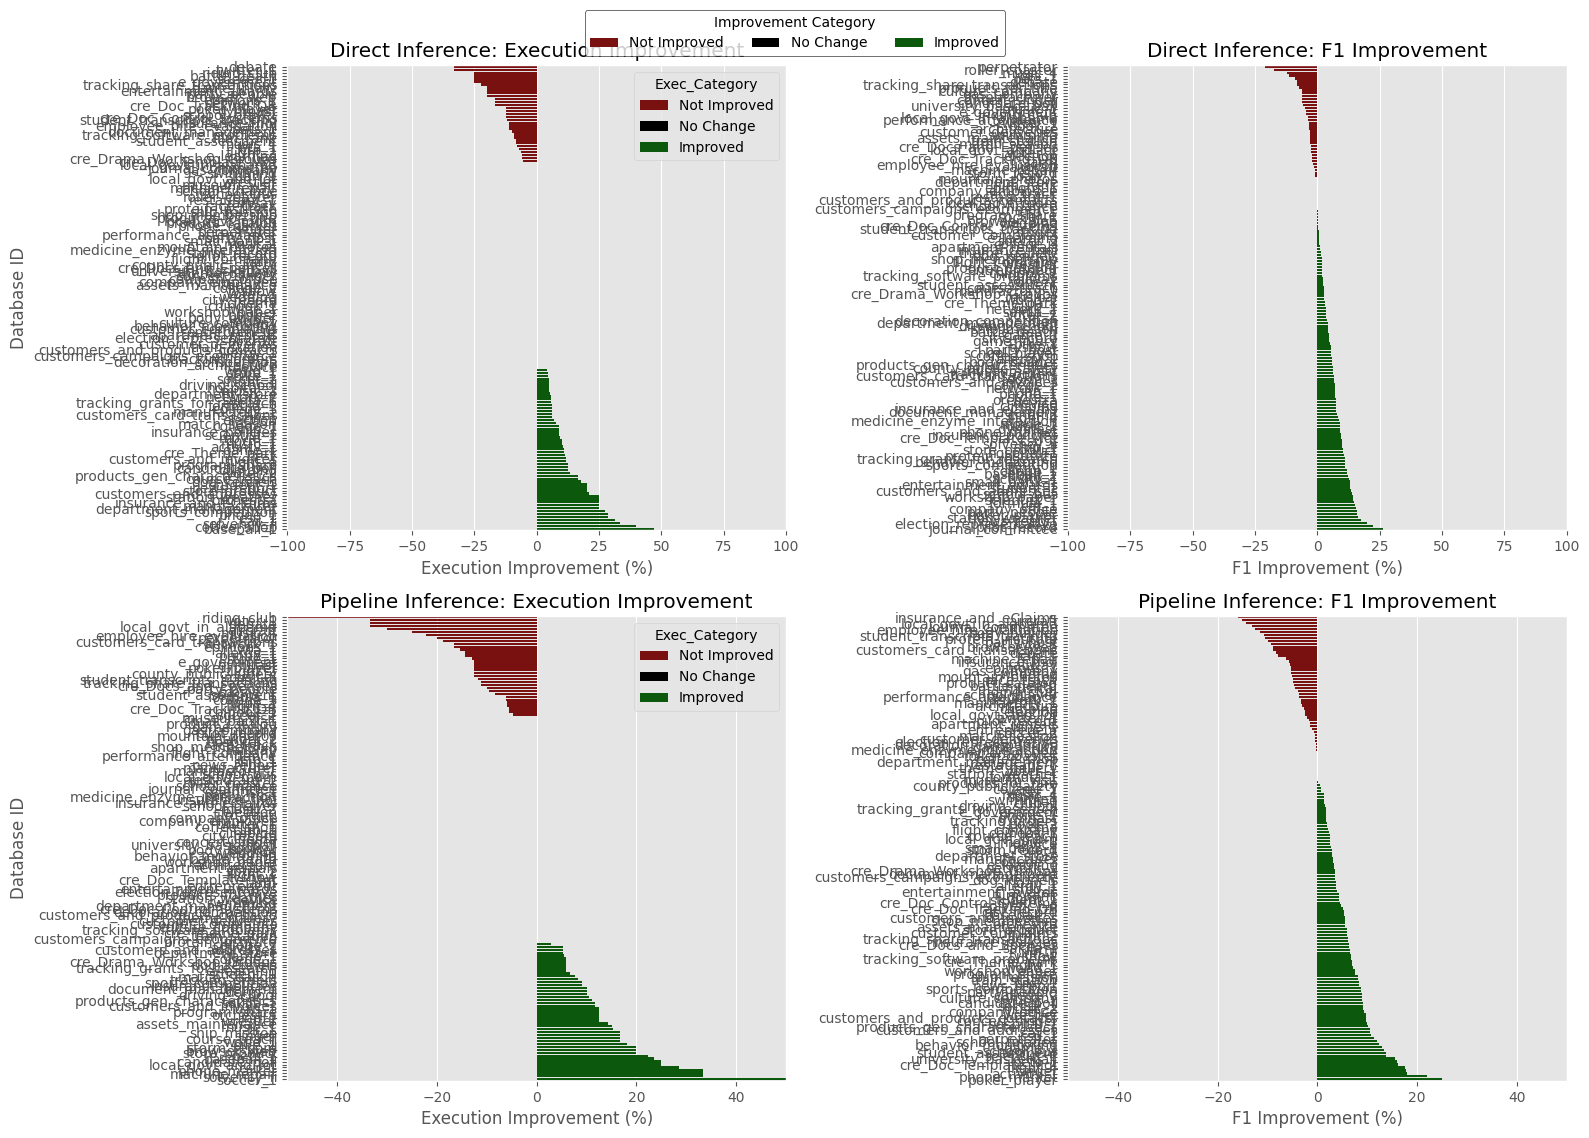

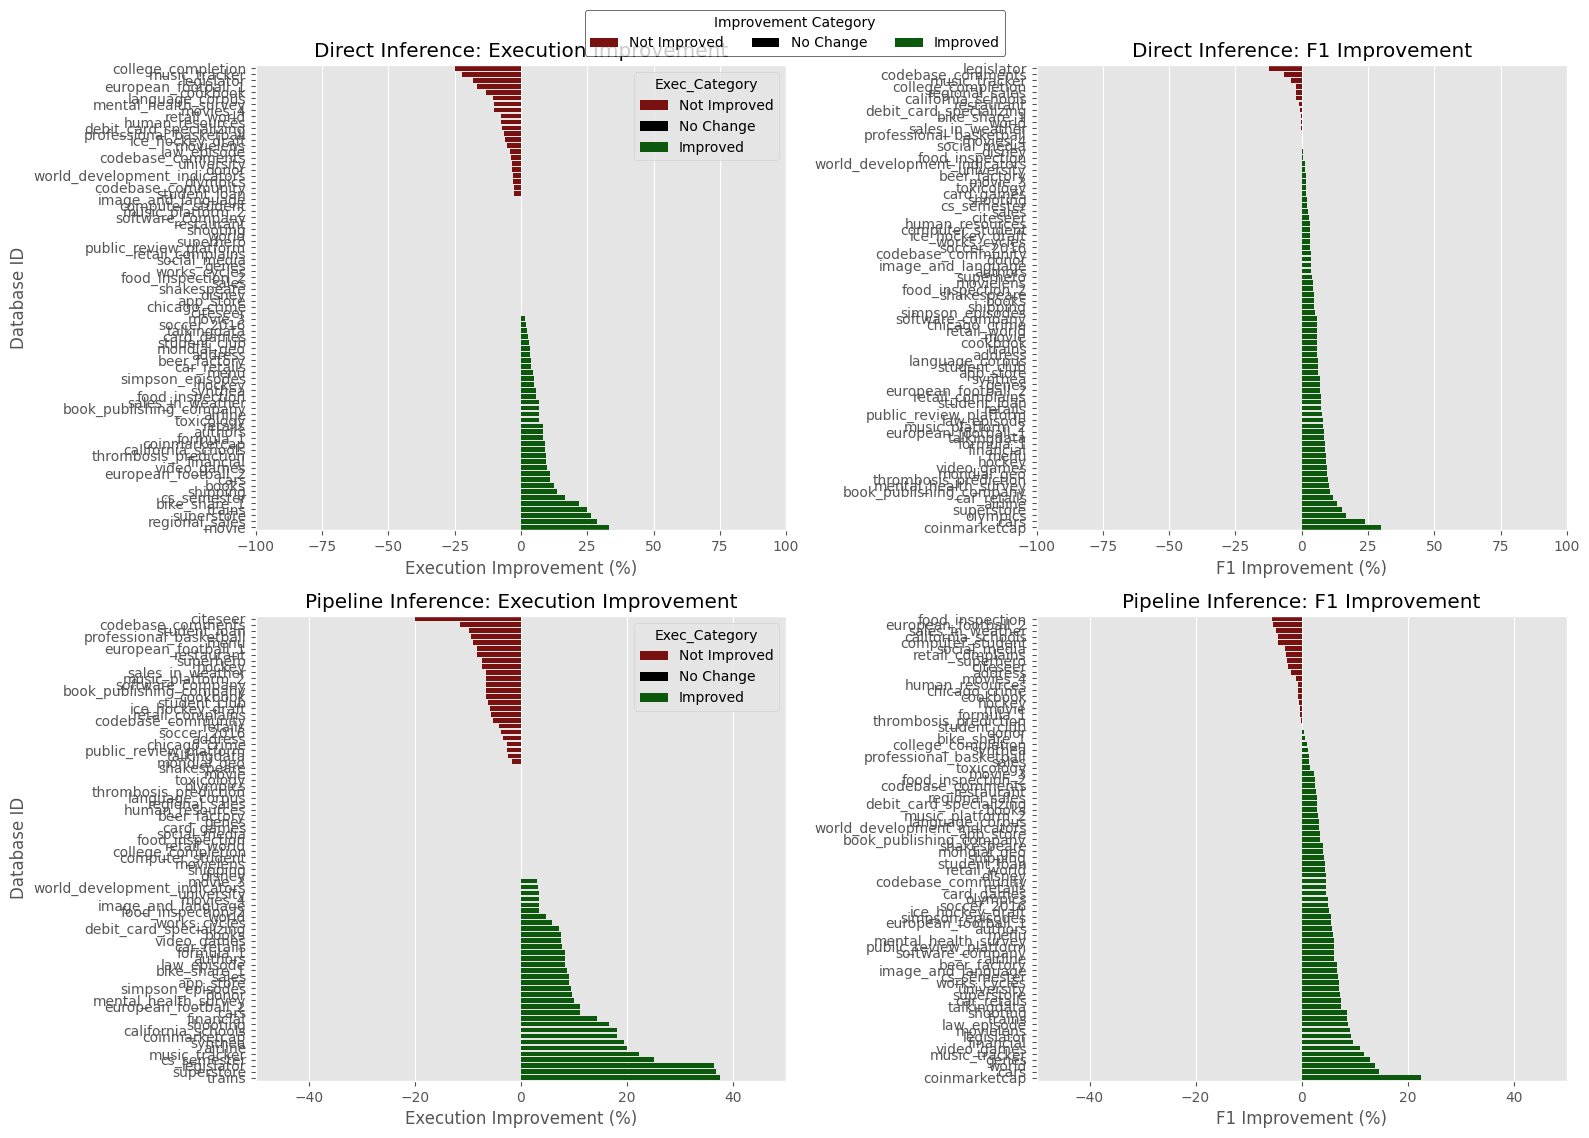

In [15]:
def categorize_improvement(x):
    if x > 0:
        return 'Improved'
    elif x == 0:
        return 'No Change'
    else:
        return 'Not Improved'
    
def categorize_improvement_simpler(x):
    if x > 0:
        return 'Improved'
    return 'Not Improved'
    
def get_performance_by_database(df: pd.DataFrame):
    # Group by database id and compute average metrics and improvement percentages
    group_db = df.groupby('db_id', observed=True)[["exec_res", "structural_score", "semantic_score", "f1_score",
        "exec_res_bo", "structural_score_bo", "semantic_score_bo", "f1_score_bo"]].mean().reset_index()

    for metric in ["exec_res", "structural_score", "semantic_score", "f1_score"]:
        bo_metric = metric + "_bo"
        group_db[metric + "_improv_pct"] = (group_db[bo_metric] - group_db[metric]) * 100
        # ((group_db[bo_metric] - group_db[metric]) / (group_db[metric] + 1e-9)) * 100

    # Summarize improvement percentages
    group_db_summary = group_db.loc[:, ['db_id', 'exec_res_improv_pct', 'structural_score_improv_pct', 'semantic_score_improv_pct', 'f1_score_improv_pct']]
    
    group_db_summary['exec_res_category'] = group_db_summary['exec_res_improv_pct'].apply(categorize_improvement_simpler).values
    group_db_summary['f1_score_category'] = group_db_summary['f1_score_improv_pct'].apply(categorize_improvement_simpler).values

    return group_db_summary

def plot_improved_vs_not_four_subplots(df_dirc: pd.DataFrame, df_pipe: pd.DataFrame):
    # Get per-database performance for both methods
    df_dirc_db = get_performance_by_database(df_dirc.copy())
    df_pipe_db = get_performance_by_database(df_pipe.copy())
    
    # Create copies and add categorical columns for execution and F1 improvements.
    # Direct Inference - Execution
    df_dirc_exec = df_dirc_db.sort_values(by='exec_res_improv_pct', ascending=True).copy()
    df_dirc_exec['Exec_Category'] = df_dirc_exec['exec_res_improv_pct'].apply(categorize_improvement)
    # Direct Inference - F1
    df_dirc_f1 = df_dirc_db.sort_values(by='f1_score_improv_pct', ascending=True).copy()
    df_dirc_f1['F1_Category'] = df_dirc_f1['f1_score_improv_pct'].apply(categorize_improvement)
    
    # Pipeline Inference - Execution
    df_pipe_exec = df_pipe_db.sort_values(by='exec_res_improv_pct', ascending=True).copy()
    df_pipe_exec['Exec_Category'] = df_pipe_exec['exec_res_improv_pct'].apply(categorize_improvement)
    # Pipeline Inference - F1
    df_pipe_f1 = df_pipe_db.sort_values(by='f1_score_improv_pct', ascending=True).copy()
    df_pipe_f1['F1_Category'] = df_pipe_f1['f1_score_improv_pct'].apply(categorize_improvement)
    
    # Define a common palette for improvement categories.
    palette = {'Improved': 'darkgreen', 'No Change': 'black', 'Not Improved': 'darkred'}
    
    # Create a figure with 2 rows x 2 columns.
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=False)
    
    # Top-left: Direct Inference - Execution Improvement
    sns.barplot(
        x='exec_res_improv_pct', y='db_id', 
        data=df_dirc_exec, 
        hue='Exec_Category', 
        dodge=False, 
        palette=palette,
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Direct Inference: Execution Improvement')
    axes[0, 0].set_xlabel('Execution Improvement (%)')
    axes[0, 0].set_ylabel('Database ID')
    axes[0, 0].set_xlim(-100, 100)
    
    # Top-right: Direct Inference - F1 Improvement
    sns.barplot(
        x='f1_score_improv_pct', y='db_id', 
        data=df_dirc_f1, 
        hue='F1_Category', 
        dodge=False, 
        palette=palette,
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Direct Inference: F1 Improvement')
    axes[0, 1].set_xlabel('F1 Improvement (%)')
    axes[0, 1].set_ylabel('')
    axes[0, 1].set_xlim(-100, 100)
    
    # Bottom-left: Pipeline Inference - Execution Improvement
    sns.barplot(
        x='exec_res_improv_pct', y='db_id', 
        data=df_pipe_exec, 
        hue='Exec_Category', 
        dodge=False, 
        palette=palette,
        ax=axes[1, 0]
    )
    axes[1, 0].set_title('Pipeline Inference: Execution Improvement')
    axes[1, 0].set_xlabel('Execution Improvement (%)')
    axes[1, 0].set_ylabel('Database ID')
    axes[1, 0].set_xlim(-50, 50)
    
    # Bottom-right: Pipeline Inference - F1 Improvement
    sns.barplot(
        x='f1_score_improv_pct', y='db_id', 
        data=df_pipe_f1, 
        hue='F1_Category', 
        dodge=False, 
        palette=palette,
        ax=axes[1, 1]
    )
    axes[1, 1].set_title('Pipeline Inference: F1 Improvement')
    axes[1, 1].set_xlabel('F1 Improvement (%)')
    axes[1, 1].set_ylabel('')
    axes[1, 1].set_xlim(-50, 50)
    
    # Remove duplicate legends in each subplot by letting only one legend per column appear.
    # Here we remove legends for the right column.
    axes[0, 1].legend().remove()
    axes[1, 1].legend().remove()
    
    # Create one common legend for the whole figure.
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc='upper center', bbox_to_anchor=(0.5, 0.95),
        ncol=3, frameon=True, facecolor='white', edgecolor='black',
        title='Improvement Category'
    )
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

plot_improved_vs_not_four_subplots(spider_dirc, spider_pipe)
plot_improved_vs_not_four_subplots(bird_dirc, bird_pipe)

In [16]:
def get_mcnemar_test2(df: pd.DataFrame):
    # Create a contingency table of paired outcomes
    contingency_table = pd.crosstab(df['exec_res_category'], df['f1_score_category'])
    print("Contingency Table for Execution Result vs. F1 Scores:")
    print(contingency_table)

    # Run McNemar's test (using exact=True for small sample sizes)
    result = mcnemar(contingency_table, exact=True)
    print("McNemar test statistic:", result.statistic, f"p-value: {round(result.pvalue, 4):.4f}", )

spider_dirc_by_db = get_performance_by_database(spider_dirc.copy())
spider_pipe_by_db = get_performance_by_database(spider_pipe.copy())
bird_dirc_by_db = get_performance_by_database(bird_dirc.copy())
bird_pipe_by_db = get_performance_by_database(bird_pipe.copy())

print('Spider Direct Inference')
get_mcnemar_test2(spider_dirc_by_db)
print('\nSpider Pipeline Inference')
get_mcnemar_test2(spider_pipe_by_db)
print('\nBIRD Direct Inference')
get_mcnemar_test2(bird_dirc_by_db)
print('\nBIRD Pipeline Inference')
get_mcnemar_test2(bird_pipe_by_db)

Spider Direct Inference
Contingency Table for Execution Result vs. F1 Scores:
f1_score_category  Improved  Not Improved
exec_res_category                        
Improved                 49             6
Not Improved             61            42
McNemar test statistic: 6.0 p-value: 0.0000

Spider Pipeline Inference
Contingency Table for Execution Result vs. F1 Scores:
f1_score_category  Improved  Not Improved
exec_res_category                        
Improved                 43             4
Not Improved             61            50
McNemar test statistic: 4.0 p-value: 0.0000

BIRD Direct Inference
Contingency Table for Execution Result vs. F1 Scores:
f1_score_category  Improved  Not Improved
exec_res_category                        
Improved                 32             4
Not Improved             35             7
McNemar test statistic: 4.0 p-value: 0.0000

BIRD Pipeline Inference
Contingency Table for Execution Result vs. F1 Scores:
f1_score_category  Improved  Not Improved
exec_re

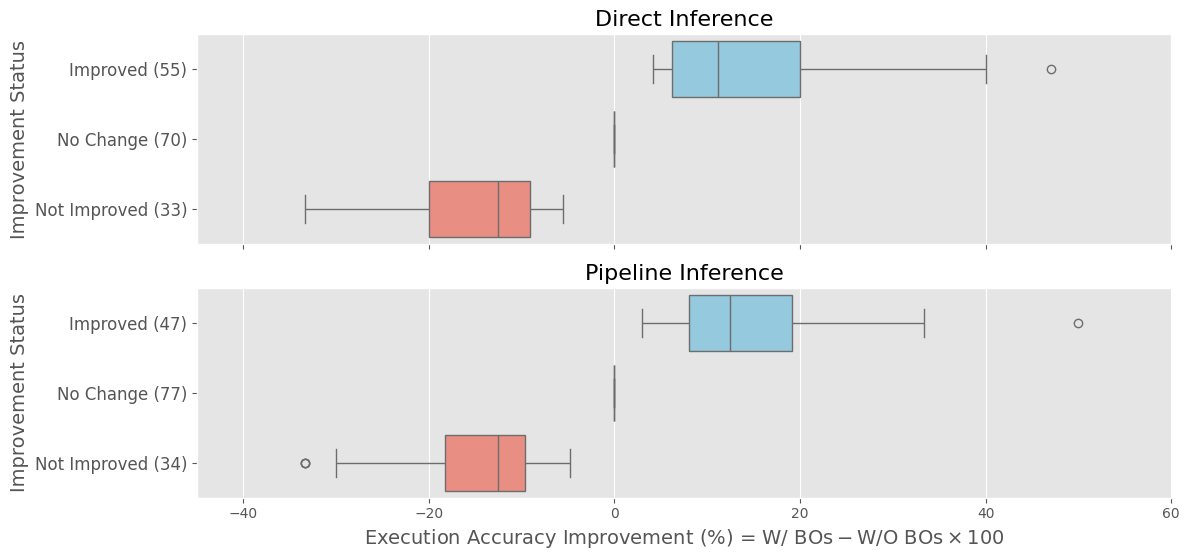

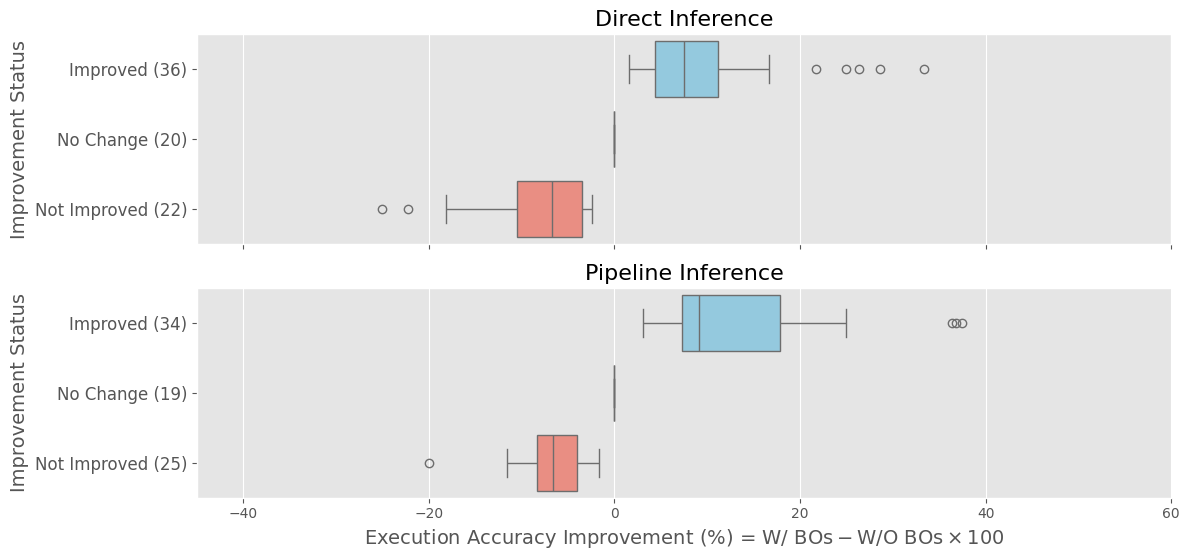

In [17]:
def performance_by_exec_improvement(df: pd.DataFrame):
    # Group by db_id: Compute average values for execution accuracy (and other metrics)
    group_db = df.groupby('db_id', observed=True)[["exec_res", "exec_res_bo",
                                                    "structural_score", "structural_score_bo",
                                                    "semantic_score", "semantic_score_bo",
                                                    "f1_score", "f1_score_bo"]].mean().reset_index()
    
    # Compute execution accuracy improvement percentage for each database
    group_db['exec_improv_pct'] = (group_db['exec_res_bo'] - group_db['exec_res']) * 100
    # ((group_db['exec_res_bo'] - group_db['exec_res']) / (group_db['exec_res'] + 1e-9)) * 100
    
    # Create a categorical variable based on whether exec accuracy improved
    
    group_db['Improvement_Status'] = group_db['exec_improv_pct'].apply(categorize_improvement)
    
    # Optionally, compute improvement percentages for the other metrics
    for metric in ["exec_res", "structural_score", "semantic_score", "f1_score"]:
        bo_metric = metric + "_bo"
        improv = (group_db[bo_metric] - group_db[metric]) * 100
        # ((group_db[bo_metric] - group_db[metric]) / (group_db[metric] + 1e-9)) * 100
        group_db[metric + '_improv_pct'] = improv

    return group_db

def plot_broken_axis_boxplots_for_methods(
    df_direct: pd.DataFrame,
    df_pipe: pd.DataFrame,
    target_metric: str,
    cates=['Improved', 'No Change', 'Not Improved'],
    left_xlim=(-60, 110),   # typical range (including negative outliers)
    right_xlim=(200, 600),   # outlier range
    suptitle="Execution Improvement Distribution by Method"
):
    """
    Create a figure with two rows (Direct and Pipeline Inference) and two columns (broken x-axis).
    The left column shows the typical range and shares its x-axis across rows.
    The right column shows the outlier range and shares its x-axis across rows.
    METRIC_MAPPING = {
        'exec_res': 'Execution Accuracy',
        'structural_score': 'Structural Score',
        'semantic_score': 'Semantic Score',
        'f1_score': 'F1 Score',
    }
    """
    # Define a custom color palette for the two categories
    custom_palette = {
        'Improved': 'skyblue',
        'No Change': 'lightyellow',
        'Not Improved': 'salmon'
    }
    METRIC_MAPPING = {
        'exec_res': 'Execution Accuracy',
        'structural_score': 'Structural Score',
        'semantic_score': 'Semantic Score',
        'f1_score': 'F1 Score',
    }
    
    improv_col = f'{target_metric}_improv_pct'
    
    xlabel = METRIC_MAPPING.get(target_metric) # ' '.join(map(str.capitalize, target_metric.split('_')))
    
    # Create a 2x2 grid with shared x-axis for each column
    fig, axes = plt.subplots(
        2, 1, 
        figsize=(12, 6), 
        # gridspec_kw={'width_ratios': [3, 1]}, 
        sharex='col'
    )
    # Axes indexing:
    # Top row: Direct Inference (ax_direct_left, ax_direct_right)
    # Bottom row: Pipeline Inference (ax_pipe_left, ax_pipe_right)
    # ax_direct_left, ax_direct_right = axes[0,0], axes[0,1]
    # ax_pipe_left, ax_pipe_right = axes[1,0], axes[1,1]
    ax_direct_left, ax_pipe_left = axes.flatten()
    
    # ----------------------
    # Plot for Direct Inference
    # ----------------------
    sns.boxplot(
        y='Improvement_Status', 
        x=improv_col, 
        data=df_direct, 
        hue='Improvement_Status', 
        palette=custom_palette,
        ax=ax_direct_left,
        order=cates,
        orient='h',
        
    )
    # sns.boxplot(
    #     y='Improvement_Status', 
    #     x=improv_col, 
    #     data=df_direct, 
    #     hue='Improvement_Status', 
    #     palette=custom_palette,
    #     ax=ax_direct_right,
    #     order=cates,
    #     orient='h'
    # )

    # add the count of each status y labels to left ax
    y_tick_labels = []
    for i, (label, value) in enumerate(df_direct['Improvement_Status'].value_counts().loc[cates].items()):
        y_tick_labels.append(f'{label} ({value})')
    ax_direct_left.set_yticks(np.arange(len(cates)))
    ax_direct_left.set_yticklabels(y_tick_labels, fontsize=12)

    # Set x-limits for Direct Inference subplots
    ax_direct_left.set_xlim(left_xlim)
    # ax_direct_right.set_xlim(right_xlim)

    # Hide y-axis labels on the right subplot
    # ax_direct_right.yaxis.set_visible(False)
    
    # Hide the right spine of left subplot and left spine of right subplot
    # ax_direct_left.spines['right'].set_visible(False)
    # ax_direct_right.spines['left'].set_visible(False)
    
    # Adjust diagonal break markers for top row (Direct Inference)
    d = 0.02  # increase d for more pronounced and symmetric slashes

    # # Left subplot: draw diagonal markers on the right boundary
    # kwargs = dict(transform=ax_direct_left.transAxes, color='k', clip_on=False, lw=1)
    # ax_direct_left.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    # ax_direct_left.plot((1 - d, 1 + d), (d, -d), **kwargs)
    # # Right subplot: draw diagonal markers on the left boundary
    # kwargs.update(transform=ax_direct_right.transAxes)
    # ax_direct_right.plot((0.03+d, -0.03-d), (1-d, 1+d), **kwargs)
    # ax_direct_right.plot((-0.03-d, 0.03+d), (-d, +d), **kwargs)

    # Set titles and labels for Direct Inference row
    ax_direct_left.set_title("Direct Inference", fontsize=16)
    ax_direct_left.set_xlabel(f'{xlabel} Improvement (%) = $\\text{{W/ BOs}} - \\text{{W/O BOs}} \\times 100$', fontsize=14)
    ax_direct_left.set_ylabel('Improvement Status', fontsize=14)
    
    # ----------------------
    # Plot for Pipeline Inference
    # ----------------------
    sns.boxplot(
        y='Improvement_Status', 
        x=improv_col, 
        data=df_pipe, 
        hue='Improvement_Status', 
        palette=custom_palette,
        ax=ax_pipe_left,
        order=cates,
        orient='h'
    )
    # sns.boxplot(
    #     y='Improvement_Status', 
    #     x=improv_col, 
    #     data=df_pipe, 
    #     hue='Improvement_Status', 
    #     palette=custom_palette,
    #     ax=ax_pipe_right,
    #     order=cates,
    #     orient='h'
    # )
    
    # add the count of each status y labels to left ax
    y_tick_labels = []
    for i, (label, value) in enumerate(df_pipe['Improvement_Status'].value_counts().loc[cates].items()):
        y_tick_labels.append(f'{label} ({value})') 
    ax_pipe_left.set_yticks(np.arange(len(cates)))
    ax_pipe_left.set_yticklabels(y_tick_labels, fontsize=12)

    # Set x-limits for Pipeline Inference subplots
    ax_pipe_left.set_xlim(left_xlim)
    # ax_pipe_right.set_xlim(right_xlim)

    # Hide y-axis labels on the right subplot
    # ax_pipe_right.yaxis.set_visible(False)
    
    # Hide the right spine of left subplot and left spine of right subplot
    ax_pipe_left.spines['right'].set_visible(False)
    # ax_pipe_right.spines['left'].set_visible(False)
    
    # Add diagonal break markers for bottom row
    # kwargs_pipe_left = dict(transform=ax_pipe_left.transAxes, color='k', clip_on=False, lw=1)
    # ax_pipe_left.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs_pipe_left)  
    # ax_pipe_left.plot((1 - d, 1 + d), (d, -d), **kwargs_pipe_left)  
    # kwargs_pipe_right = dict(transform=ax_pipe_right.transAxes, color='k', clip_on=False, lw=1)
    # ax_pipe_right.plot((0.03+d, -0.03-d), (1-d, 1+d), **kwargs_pipe_right)
    # ax_pipe_right.plot((-0.03-d, 0.03+d), (-d, +d), **kwargs_pipe_right)

    # Set titles and labels for Pipeline Inference row
    ax_pipe_left.set_title("Pipeline Inference", fontsize=16)
    # ax_pipe_left.set_xlabel(f'{xlabel} Improvement (%) = $\\frac{{\\text{{W/ BOs}} - \\text{{W/O BOs}}}}{{\\text{{W/O BOs}}}} \\times 100$', fontsize=14)
    ax_pipe_left.set_xlabel(f'{xlabel} Improvement (%) = $\\text{{W/ BOs}} - \\text{{W/O BOs}} \\times 100$', fontsize=14)
    ax_pipe_left.set_ylabel('Improvement Status', fontsize=14)
    
    # Adjust y-tick labels if needed (right subplots already hide y-axis)
    # ax_direct_right.tick_params(left=False, labelleft=False)
    # ax_pipe_right.tick_params(left=False, labelleft=False)
    
    # Add a super title to the whole figure
    if suptitle:
        fig.suptitle(suptitle, fontsize=16)
    
    # ax_pipe_right.set_xlabel("")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    return fig

cates = ['Improved', 'No Change', 'Not Improved']

spider_per_dirc = performance_by_exec_improvement(spider_dirc)
spider_per_pipe = performance_by_exec_improvement(spider_pipe)

spider_fig = plot_broken_axis_boxplots_for_methods(
    spider_per_dirc, spider_per_pipe, target_metric='exec_res', cates=cates,
    left_xlim=(-45, 60), right_xlim=(200, 450), 
    suptitle=""
)
spider_fig.savefig(f'temp/execution-improvement-spider.pdf', dpi=300, bbox_inches='tight')
bird_per_dirc = performance_by_exec_improvement(bird_dirc)
bird_per_pipe = performance_by_exec_improvement(bird_pipe)

bird_fig = plot_broken_axis_boxplots_for_methods(
    bird_per_dirc, bird_per_pipe, target_metric='exec_res', cates=cates,
    left_xlim=(-45, 60), right_xlim=(200, 450), 
    suptitle=""
)
bird_fig.savefig(f'temp/execution-improvement-bird.pdf', dpi=300, bbox_inches='tight')

## Percentage of Improvements Transitions

In [18]:
from sklearn.metrics import confusion_matrix
from matplotlib.gridspec import GridSpec

def get_cm(df: pd.DataFrame, performance_improv: pd.DataFrame, cate='No Change'):
    if cate != '':
        db_ids = performance_improv.loc[performance_improv['Improvement_Status'] == cate, 'db_id'].tolist()
    else:
        db_ids = performance_improv['db_id'].tolist()
    df_cate = df.loc[df['db_id'].isin(db_ids)]

    cm = confusion_matrix(y_true=df_cate['exec_res'], y_pred=df_cate['exec_res_bo'], labels=[0, 1])
    # row(index) is true=exec_res, column is pred = exec_res_bo
    index = pd.MultiIndex.from_tuples([('Without BOs', 'Fail'), ('Without BOs', 'Success')])
    column = pd.MultiIndex.from_tuples([('With BOs', 'Fail'), ('With BOs', 'Success')])
    df_cm = pd.DataFrame(cm, index=index, columns=column)
    return df_cm

def get_transition(df: pd.DataFrame, f: int, t: int):
    # f: from, t: to | 0: fail, 1: success
    df_sub = df.loc[(df['exec_res'] == f) & (df['exec_res_bo'] == t)]
    return df_sub

def plot_complexity_dist(
        df_dirc: pd.DataFrame, df_pipe: pd.DataFrame, cate: str='', n_bins=10
    ):
    df_dirc = df_dirc.copy()
    df_pipe = df_pipe.copy()
    if cate != '':
        performance_improv_dirc = performance_by_exec_improvement(df_dirc)
        performance_improv_pipe = performance_by_exec_improvement(df_pipe)
        db_ids_dirc = performance_improv_dirc.loc[performance_improv_dirc['Improvement_Status'] == cate, 'db_id'].tolist()
        df_dirc = df_dirc.loc[df_dirc['db_id'].isin(db_ids_dirc)]
        db_ids_pipe = performance_improv_pipe.loc[performance_improv_pipe['Improvement_Status'] == cate, 'db_id'].tolist()
        df_pipe = df_pipe.loc[df_pipe['db_id'].isin(db_ids_pipe)]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    ax_dirc, ax_pipe = axes
    custom_palette = {
        '01': 'cornflowerblue',
        '10': 'tomato'
    }

    for df, ax, title in zip([df_dirc, df_pipe], [ax_dirc, ax_pipe], ['Direct Inference', 'Pipeline Inference']):
        df_01 = get_transition(df, 0, 1)
        df_10 = get_transition(df, 1, 0)
        sns.histplot(df_01['target_complexity'], bins=n_bins, color=custom_palette['01'], 
                     label=f'Fail $\\rightarrow$ Success ({len(df_01)})', alpha=0.7, kde=True, ax=ax)
        sns.histplot(df_10['target_complexity'], bins=n_bins, color=custom_palette['10'],
                        label=f'Success $\\rightarrow$ Fail ({len(df_10)})', alpha=0.7, kde=True, ax=ax)
        ax.set_xlabel('Target Complexity')
        ax.set_ylabel('Frequency')
        ax.set_title(title)
        ax.legend(
            # bbox_to_anchor=(1.1, -0.35), 
            loc='upper right', 
            title='Without BOs $\\rightarrow$ With BOs',
            frameon=True, facecolor='white', edgecolor='black'
        )
    plt.tight_layout()
    plt.show()

    return fig

def get_values_counts(df: pd.DataFrame, complexity_cates: list[str], f: int, t: int):
    df_ft = get_transition(df, f, t)
    df_ft = df_ft['cates'].value_counts()
    if len(df_ft) < len(complexity_cates):
        for c in complexity_cates:
            if c not in df_ft.index:
                df_ft[c] = 0
    df_ft = df_ft.loc[complexity_cates].reset_index()
    df_ft['percentage'] = df_ft['count'] / df_ft['count'].sum() * 100
    return df_ft

def barplot_by_complexity_cates(
        df_dirc: pd.DataFrame, df_pipe: pd.DataFrame, complexity_cates: list[str], cate: str='',
        number_type: str|None = None
    ):

    def plot_stacked_barplot(df: pd.DataFrame, ax, palette, position: int, bar_width=0.5, number_type: str|None = None):
        """number_type: None, 'count' or 'percentage', text of number on the bar"""
        bottom = 0
        for i, row in df.iterrows():
            ax.bar(position, row['percentage'], bottom=bottom, width=bar_width, label=row['cates'], color=palette[i])
            if number_type is not None: 
                if row[number_type] > 0:
                    text = f"{row[number_type]}" if number_type == 'count' else f"{row[number_type]:.2f} %"
                    ax.text(position, bottom + row['percentage']/2,  # position + bar_width/2: put it on the right side of the bar
                        text, ha='center', va='center', color='black', fontsize=10)
            bottom += row['percentage']

    df_dirc = df_dirc.copy()
    df_pipe = df_pipe.copy()
    if cate != '':
        performance_improv_dirc = performance_by_exec_improvement(df_dirc)
        performance_improv_pipe = performance_by_exec_improvement(df_pipe)
        db_ids_dirc = performance_improv_dirc.loc[performance_improv_dirc['Improvement_Status'] == cate, 'db_id'].tolist()
        df_dirc = df_dirc.loc[df_dirc['db_id'].isin(db_ids_dirc)]
        db_ids_pipe = performance_improv_pipe.loc[performance_improv_pipe['Improvement_Status'] == cate, 'db_id'].tolist()
        df_pipe = df_pipe.loc[df_pipe['db_id'].isin(db_ids_pipe)]

    # Create a GridSpec with 2 rows:
    # - First row: 2 columns for the two barplots.
    # - Second row: 1 column spanning both for the legend.
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 2, height_ratios=[4, 1], hspace=0.15, )
    
    # Top row subplots
    ax_dirc = fig.add_subplot(gs[0, 0])
    ax_pipe = fig.add_subplot(gs[0, 1], sharey=ax_dirc)
    
    # Use a common color palette for complexity categories.
    palette = sns.color_palette('RdYlGn', 5).as_hex()[::-1]
    
    # For each method, get the count data and plot stacked bars.
    # get_values_counts is assumed to be a helper function that returns a DataFrame
    # with columns: 'cates' and 'count' and 'percentage' computed.
    for df, ax, title in zip([df_dirc, df_pipe], [ax_dirc, ax_pipe], ['Direct Inference', 'Pipeline Inference']):
        df_01 = get_values_counts(df, complexity_cates, 0, 1)
        df_10 = get_values_counts(df, complexity_cates, 1, 0)
        
        bar_width = 0.4
        plot_stacked_barplot(df_01, ax, palette, position=0, bar_width=bar_width, number_type=number_type)
        plot_stacked_barplot(df_10, ax, palette, position=1, bar_width=bar_width, number_type=number_type)
    
        ax.set_xticks([0, 1])
        ax.set_xticklabels([
            f'Fail $\\rightarrow$ Success\n({df_01["count"].sum()} samples)', 
            f'Success $\\rightarrow$ Fail\n({df_10["count"].sum()} samples)'
        ])
        ax.set_xlabel('Execution Result Transition\n(Without BOs $\\rightarrow$ With BOs)')
        ax.set_ylabel('Percentage (%)')
        ax.set_title(title)
    
    # Create a fake axes for the legend in the bottom row spanning both columns.
    ax_legend = fig.add_subplot(gs[1, :])
    ax_legend.axis('off')  # Hide the fake axes
    # Build legend handles using rectangles.
    handles = [plt.Rectangle((0,0), 1, 1, fc=palette[i]) for i in range(len(complexity_cates))]
    # Place the legend at the bottom.
    ax_legend.legend(
        handles, complexity_cates,
        ncol=len(complexity_cates),
        title='Complexity Categories',
        frameon=True, facecolor='white', edgecolor='black',
        loc='center',
        bbox_to_anchor=(0.5, 0.2)
    )
    
    plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=0.0)
    plt.show()

    return fig

== Spider Direct Inference ==
                    With BOs        
                        Fail Success
Without BOs Fail         307     127
            Success       69    1196

== Spider Pipeline Inference ==
                    With BOs        
                        Fail Success
Without BOs Fail         298     122
            Success       95    1184


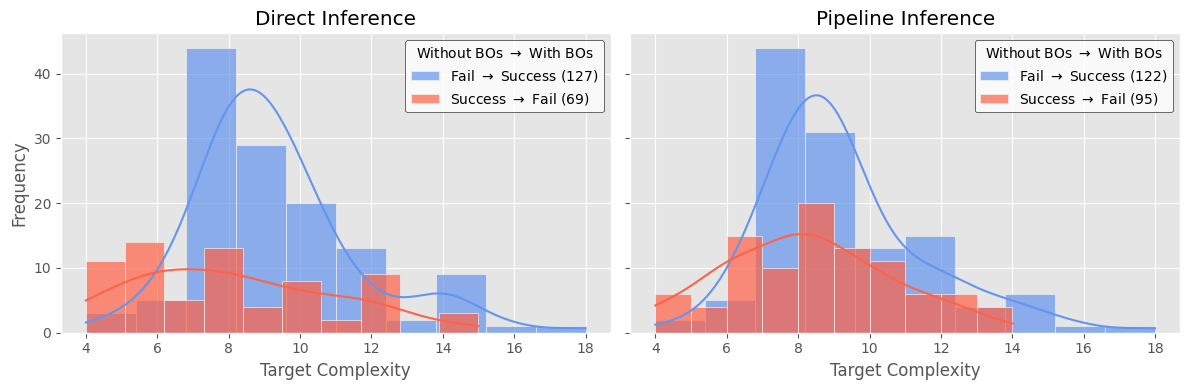

/tmp/ipykernel_266395/3914217529.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=0.0)


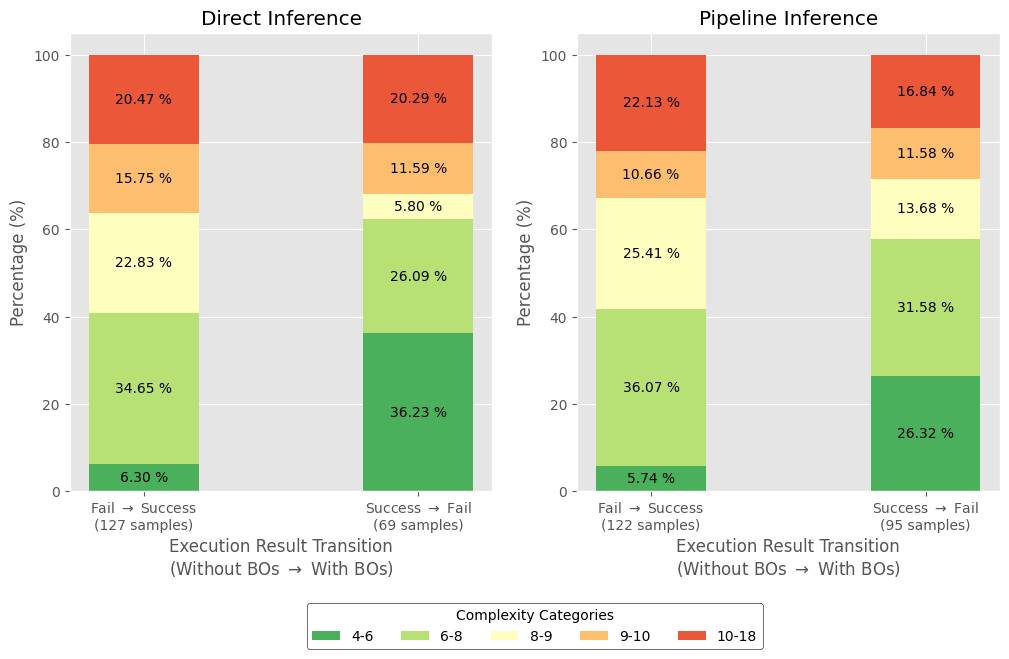


== BIRD Direct Inference ==
                    With BOs        
                        Fail Success
Without BOs Fail        1123     153
            Success      110     633

== BIRD Pipeline Inference ==
                    With BOs        
                        Fail Success
Without BOs Fail        1010     181
            Success      135     693


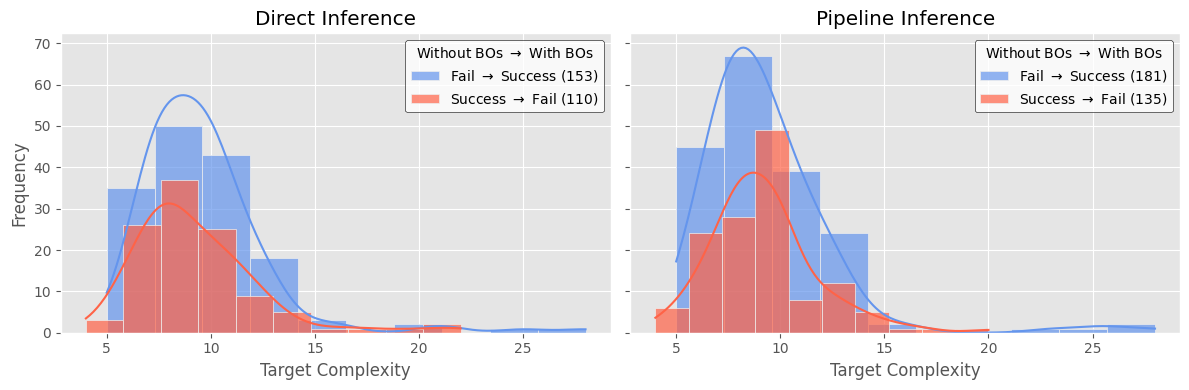

/tmp/ipykernel_266395/3914217529.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=0.0)


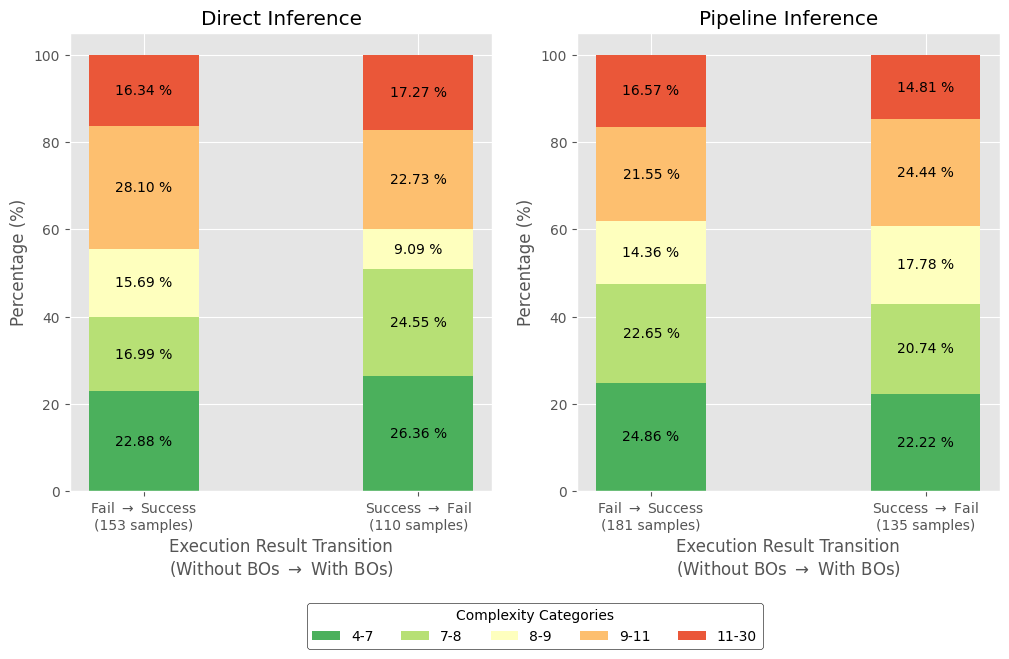

In [19]:
cates = ['Improved', 'No Change', 'Not Improved']

spider_per_dirc = performance_by_exec_improvement(spider_dirc)
spider_per_pipe = performance_by_exec_improvement(spider_pipe)

bird_per_dirc = performance_by_exec_improvement(bird_dirc)
bird_per_pipe = performance_by_exec_improvement(bird_pipe)

# overall
cate = ''

spider_cm_dirc = get_cm(spider_dirc, spider_per_dirc, cate)
print('== Spider Direct Inference ==')
print(spider_cm_dirc)
spider_cm_pipe = get_cm(spider_pipe, spider_per_pipe, cate)
print('\n== Spider Pipeline Inference ==')
print(spider_cm_pipe)

# print(spider_dirc['cates'].unique())
spider_complexity_cates = ['4-6', '6-8', '8-9', '9-10', '10-18']
fig = plot_complexity_dist(spider_dirc, spider_pipe, cate, n_bins=10)
fig_complexity_cates = barplot_by_complexity_cates(spider_dirc, spider_pipe, spider_complexity_cates, cate, number_type='percentage')
fig_complexity_cates.savefig(f'temp/complexity-cates-spider.pdf', dpi=300, bbox_inches='tight')

bird_cm_dirc = get_cm(bird_dirc, bird_per_dirc, cate)
print('\n== BIRD Direct Inference ==')
print(bird_cm_dirc)
bird_cm_pipe = get_cm(bird_pipe, bird_per_pipe, cate)
print('\n== BIRD Pipeline Inference ==')
print(bird_cm_pipe)

# print(bird_dirc['cates'].unique())
bird_complexity_cates = ['4-7', '7-8', '8-9', '9-11', '11-30']
fig = plot_complexity_dist(bird_dirc, bird_pipe, cate, n_bins=10)
fig_complexity_cates = barplot_by_complexity_cates(bird_dirc, bird_pipe, bird_complexity_cates, cate, number_type='percentage')
fig_complexity_cates.savefig(f'temp/complexity-cates-bird.pdf', dpi=300, bbox_inches='tight')

## Execution Accuracy By Complexity

/tmp/ipykernel_266395/4021033421.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(custom_order, fontsize=14)
/tmp/ipykernel_266395/4021033421.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(custom_order, fontsize=14)


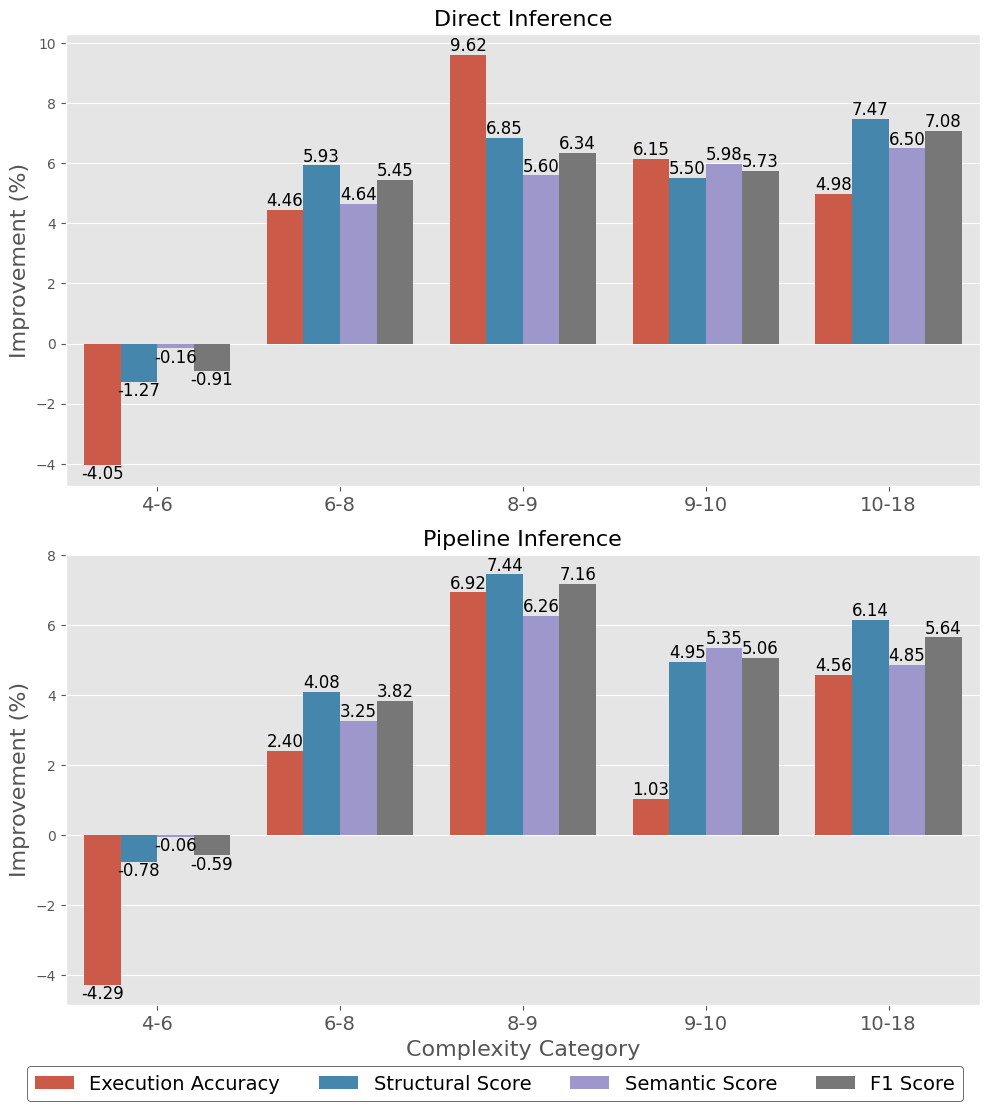

/tmp/ipykernel_266395/4021033421.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(custom_order, fontsize=14)
/tmp/ipykernel_266395/4021033421.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(custom_order, fontsize=14)


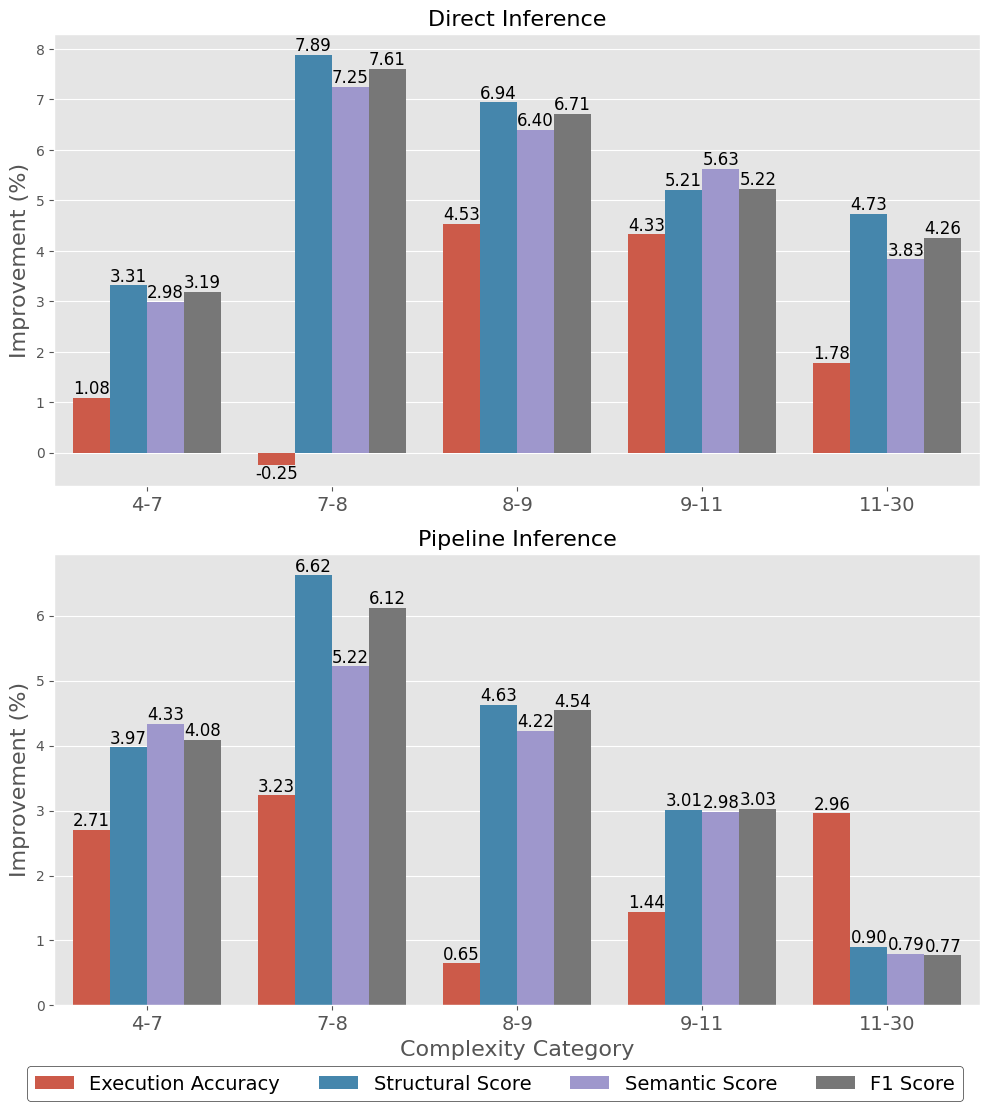

In [20]:
def get_performance_by_complexity(df: pd.DataFrame, custom_order: list[str]):
    group_complex = df.groupby('cates', observed=True)[
        ["exec_res", "structural_score", "semantic_score", "f1_score",
         "exec_res_bo", "structural_score_bo", "semantic_score_bo", "f1_score_bo"]
    ].mean().reset_index()
    
    for metric in ["exec_res", "structural_score", "semantic_score", "f1_score"]:
        bo_metric = metric + "_bo"
        group_complex[metric + "_improv_pct"] = (group_complex[bo_metric] - group_complex[metric]) * 100
        # ((group_complex[bo_metric] - group_complex[metric]) / (group_complex[metric] + 1e-9)) * 100
        
    group_complex_summary = group_complex[['cates', 
                                           'exec_res_improv_pct', 
                                           'structural_score_improv_pct', 
                                           'semantic_score_improv_pct', 
                                           'f1_score_improv_pct']]
    
    # Ensure the rows follow the custom order
    return group_complex_summary.set_index('cates').loc[custom_order].reset_index()

def plot_performance_by_complexity_two_methods(
    df_direct: pd.DataFrame,
    df_pipe: pd.DataFrame,
    custom_order: list[str],
    suptitle: str = "Performance Improvement by Complexity Category"
):
    # Get summaries for each method
    direct_summary = get_performance_by_complexity(df_direct.copy(), custom_order)
    pipe_summary   = get_performance_by_complexity(df_pipe.copy(), custom_order)
    
    # Melt the data so that each row represents one metric's improvement
    metrics = ['exec_res_improv_pct', 'structural_score_improv_pct', 'semantic_score_improv_pct', 'f1_score_improv_pct']
    direct_melted = pd.melt(
        direct_summary, 
        id_vars='cates', 
        value_vars=metrics, 
        var_name='Metric', 
        value_name='Improvement (%)'
    )
    pipe_melted = pd.melt(
        pipe_summary, 
        id_vars='cates', 
        value_vars=metrics, 
        var_name='Metric', 
        value_name='Improvement (%)'
    )
    
    # Create a figure with two rows (one per method) and share the x-axis for both rows
    fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=False)
    
    # Plot Direct Inference data in the top subplot
    sns.barplot(
        x='cates', y='Improvement (%)', hue='Metric', data=direct_melted, ax=axes[0]
    )
    axes[0].set_title("Direct Inference", fontsize=16)
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Improvement (%)", fontsize=16)
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.2f', label_type='edge', fontsize=12)
    axes[0].set_xticklabels(custom_order, fontsize=14)
    
    # Plot Pipeline Inference data in the bottom subplot
    sns.barplot(
        x='cates', y='Improvement (%)', hue='Metric', data=pipe_melted, ax=axes[1]
    )
    axes[1].set_title("Pipeline Inference", fontsize=16)
    axes[1].set_xlabel("Complexity Category", fontsize=16)
    axes[1].set_ylabel("Improvement (%)", fontsize=16)
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.2f', label_type='edge', fontsize=12)
    axes[1].set_xticklabels(custom_order, fontsize=14)
    # Remove legends from individual subplots
    axes[0].legend().remove()
    axes[1].legend().remove()
    
    # Create a common legend outside the figure
    handles, labels = axes[0].get_legend_handles_labels()
    labels_mapping = {
        'exec_res_improv_pct': 'Execution Accuracy',
        'structural_score_improv_pct': 'Structural Score',
        'semantic_score_improv_pct': 'Semantic Score',
        'f1_score_improv_pct': 'F1 Score'
    }
    legend = fig.legend(
        handles, [labels_mapping[label] for label in labels],
        loc='lower center', bbox_to_anchor=(0.5, -0.03),
        fontsize=14,
        ncol=4, frameon=True, facecolor='white', edgecolor='black'
    )
    
    # fig.suptitle(suptitle, fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()
    return fig

spider_complexity_cates = ['4-6', '6-8', '8-9', '9-10', '10-18']
spider_dirc_per_complexity = get_performance_by_complexity(spider_dirc.copy(), spider_complexity_cates)
spider_pipe_per_complexity = get_performance_by_complexity(spider_pipe.copy(), spider_complexity_cates)

spider_fig = plot_performance_by_complexity_two_methods(spider_dirc, spider_pipe, spider_complexity_cates)
spider_fig.savefig(f'temp/execution-improvement-by-complexity-spider.pdf', dpi=300, bbox_inches='tight')

bird_complexity_cates = ['4-7', '7-8', '8-9', '9-11', '11-30']
bird_dirc_per_complexity = get_performance_by_complexity(bird_dirc.copy(), bird_complexity_cates)
bird_pipe_per_complexity = get_performance_by_complexity(bird_pipe.copy(), bird_complexity_cates)

bird_fig = plot_performance_by_complexity_two_methods(bird_dirc, bird_pipe, bird_complexity_cates)
bird_fig.savefig(f'temp/execution-improvement-by-complexity-bird.pdf', dpi=300, bbox_inches='tight')

In [21]:
spider_cates = ['4-6', '6-8', '8-9', '9-10', '10-18']
bird_cates = ['4-7', '7-8', '8-9', '9-11', '11-30']

with (proj_path / 'direct_exp' / 'spider' / 'predictions' / 'create_bo' / f'final_spider_test_bo.json').open() as f:
    spider_bos_dirc = remove_duplicate_bos(json.load(f))

with (proj_path / 'pipeline_exp' / 'spider' / 'predictions' / 'create_bo' / f'final_spider_test_bo.json').open() as f:
    spider_bos_pipe = remove_duplicate_bos(json.load(f))

with (proj_path / 'direct_exp' / 'bird' / 'predictions' / 'create_bo' / f'final_bird_test_bo.json').open() as f:
    bird_bos_dirc = remove_duplicate_bos(json.load(f))

with (proj_path / 'pipeline_exp' / 'bird' / 'predictions' / 'create_bo' / f'final_bird_test_bo.json').open() as f:
    bird_bos_pipe = remove_duplicate_bos(json.load(f))

df_10 = get_transition(spider_dirc.copy(), 1, 0)
df_00 = get_transition(spider_dirc.copy(), 0, 0)
print('Spider Success to Fail')
print(df_10.groupby(['cates', 'bo_cates'])['db_id'].size().unstack().loc[spider_cates, spider_cates].fillna(0).astype(int))
print('Spider Fail to Fail')
print(df_00.groupby(['cates', 'bo_cates'])['db_id'].size().unstack().loc[spider_cates, spider_cates].fillna(0).astype(int))

Spider Success to Fail
bo_cates  4-6  6-8  8-9  9-10  10-18
cates                               
4-6         3    6    4     4      5
6-8         1   11    0     2      2
8-9         1    1    0     0      2
9-10        0    2    0     1      3
10-18       0    0    1     3      8
Spider Fail to Fail
bo_cates  4-6  6-8  8-9  9-10  10-18
cates                               
4-6         2    4    5     1      6
6-8         3   33   20    18     23
8-9         9   14    9    16     12
9-10        1    8    2     3     17
10-18       2   12    7    12     39


In [22]:
def get_sample(test_samples, test_inferences, bos, db_id, sample_id, target_complexity, file=None):
    print(f'============ {db_id}{sample_id} - Complexity: {target_complexity} ============', file=file)
    sample = list(filter(lambda x: x.sample_id == sample_id, test_samples))[0]
    print('[ Query]', sample.final.question, file=file)
    print('[Target]', sample.final.sql, file=file)
    pred = list(filter(lambda x: x['sample_id'] == sample_id, test_inferences))[0]
    print('[ Pred ]', pred['sql'], file=file)
    if pred['doc_ids'] == []:
        print('[  VT  ]', 'No BOs', file=file)
    else:
        bo_id = pred['doc_ids'][0]
        bo = list(filter(lambda x: x['sample_id'] == bo_id, bos[db_id]))[0]
        print('[  VT  ]', bo['vt'], file=file)
        print('[  BA  ]', bo['ba'], file=file)
        print('[ BO-C ]', bo['gold_complexity'], file=file)

def print_cate_errors(test_samples, test_inferences, bos, df, cate, filename=None):
    if filename is not None:
        file = Path(filename).open('w')
    else:
        file = None
    for i, row in df.loc[df['cates'] == cate, ['sample_id', 'db_id', 'target_complexity']].iterrows():
        sample_id = row['sample_id']
        db_id = row['db_id']
        target_complexity = row['target_complexity']
        get_sample(test_samples, test_inferences, bos, db_id, sample_id, target_complexity, file=file)

df_10 = get_transition(spider_dirc.copy(), 1, 0)
df_00 = get_transition(spider_dirc.copy(), 0, 0)
print_cate_errors(spider_test_samples, spider_test_inference_dirc, spider_bos_dirc, 
                  df_10, '4-6', filename='./temp/spider_dirc_10_4-6.txt')
print_cate_errors(spider_test_samples, spider_test_inference_dirc, spider_bos_dirc, 
                  df_10, '10-18', filename='./temp/spider_dirc_10_10-18.txt')
print_cate_errors(spider_test_samples, spider_test_inference_dirc, spider_bos_dirc, 
                  df_00, '4-6', filename='./temp/spider_dirc_00_4-6.txt')
print_cate_errors(spider_test_samples, spider_test_inference_dirc, spider_bos_dirc,
                  df_00, '10-18', filename='./temp/spider_dirc_00_10-18.txt')

df_10 = get_transition(spider_pipe.copy(), 1, 0)
df_00 = get_transition(spider_pipe.copy(), 0, 0)
print_cate_errors(spider_test_samples, spider_test_inference_pipe, spider_bos_pipe, 
                  df_10, '4-6', filename='./temp/spider_pipe_10_4-6.txt')
print_cate_errors(spider_test_samples, spider_test_inference_pipe, spider_bos_pipe,
                    df_10, '10-18', filename='./temp/spider_pipe_10_10-18.txt')
print_cate_errors(spider_test_samples, spider_test_inference_pipe, spider_bos_pipe,
                    df_00, '4-6', filename='./temp/spider_pipe_00_4-6.txt')
print_cate_errors(spider_test_samples, spider_test_inference_pipe, spider_bos_pipe,
                    df_00, '10-18', filename='./temp/spider_pipe_00_10-18.txt')

df_10 = get_transition(bird_dirc.copy(), 1, 0)
df_00 = get_transition(bird_dirc.copy(), 0, 0)
print_cate_errors(bird_test_samples, bird_test_inference_dirc, bird_bos_dirc, 
                  df_10, '4-7', filename='./temp/bird_dirc_10_4-7.txt')
print_cate_errors(bird_test_samples, bird_test_inference_dirc, bird_bos_dirc,
                    df_10, '11-30', filename='./temp/bird_dirc_10_11-30.txt')
print_cate_errors(bird_test_samples, bird_test_inference_dirc, bird_bos_dirc,
                    df_00, '4-7', filename='./temp/bird_dirc_00_4-7.txt')
print_cate_errors(bird_test_samples, bird_test_inference_dirc, bird_bos_dirc,
                    df_00, '11-30', filename='./temp/bird_dirc_00_11-30.txt')

df_10 = get_transition(bird_pipe.copy(), 1, 0)
df_00 = get_transition(bird_pipe.copy(), 0, 0)
print_cate_errors(bird_test_samples, bird_test_inference_pipe, bird_bos_pipe, 
                  df_10, '4-7', filename='./temp/bird_pipe_10_4-7.txt')
print_cate_errors(bird_test_samples, bird_test_inference_pipe, bird_bos_pipe,
                    df_10, '11-30', filename='./temp/bird_pipe_10_11-30.txt')
print_cate_errors(bird_test_samples, bird_test_inference_pipe, bird_bos_pipe,
                    df_00, '4-7', filename='./temp/bird_pipe_00_4-7.txt')
print_cate_errors(bird_test_samples, bird_test_inference_pipe, bird_bos_pipe,
                    df_00, '11-30', filename='./temp/bird_pipe_00_11-30.txt')

In [ ]:
for i, row in df_10.loc[df_10['cates'] == '10-18', ['sample_id', 'db_id']].iterrows():
    sample_id = row['sample_id']
    db_id = row['db_id'] 
    print(f'============ {sample_id} ================')
    get_sample(spider_test_samples, spider_test_inference_dirc, spider_bos_dirc, db_id, sample_id)

In [ ]:
db_id = 'game_1'
sample_id = 5966

def get_sample(test_samples, test_inferences, bos, db_id, sample_id):
    sample = list(filter(lambda x: x.sample_id == sample_id, test_samples))[0]
    print(sample.final.sql)
    pred = list(filter(lambda x: x['sample_id'] == sample_id, test_inferences))[0]
    print(pred['sql'])
    bo_id = pred['doc_ids'][0]
    bo = list(filter(lambda x: x['sample_id'] == bo_id, bos[db_id]))[0]
    print(bo['vt'])

get_sample(spider_test_samples, spider_test_inferences, spider_bos_dirc, db_id, sample_id)

In [ ]:
df_10 = get_transition(spider_pipe.copy(), 1, 0)
df_00 = get_transition(spider_pipe.copy(), 0, 0)
print('Spider Success to Fail')
print(df_10.groupby(['cates', 'bo_cates'])['db_id'].size().unstack().loc[spider_cates, spider_cates].fillna(0).astype(int))
print('Spider Fail to Fail')
print(df_00.groupby(['cates', 'bo_cates'])['db_id'].size().unstack().loc[spider_cates, spider_cates].fillna(0).astype(int))

In [ ]:
spider_pipe.groupby(['cates', 'bo_cates'])['db_id'].size().unstack().loc[spider_cates, spider_cates]

## Retrieved Samples are Target Complexity

* can we say the BOs help LLMs to better understand the complexity? (Execution accruacy Improvement and retrieved complexity)

In [ ]:
spider_pipe.columns

In [ ]:
import matplotlib.colors as mcolors

def get_scores_by_cates(df: pd.DataFrame):
    # df = df.copy().loc[:, ['cates', 'bo_cates', 'exec_res_bo', 'exec_res', 'f1_score_bo', 'f1_score']]
    df = df.copy()
    df['exec_diff'] = (df['exec_res_bo'] - df['exec_res']) * 100
    df['f1_diff'] = (df['f1_score_bo'] - df['f1_score']) * 100

    df = df.loc[:, ['cates', 'bo_cates', 'exec_diff', 'f1_diff']]
    exec_diff = df.groupby(['cates', 'bo_cates'])['exec_diff'].agg(['mean', 'std', 'count']).unstack()
    f1_diff = df.groupby(['cates', 'bo_cates'])['f1_diff'].agg(['mean', 'std', 'count']).unstack()
    
    return exec_diff, f1_diff

def draw_heatmap(spider_diff: pd.DataFrame, bird_diff: pd.DataFrame, cbar_label='Execution Improvement (%)'):
    spider_cates = ['4-6', '6-8', '8-9', '9-10', '10-18']
    bird_cates = ['4-7', '7-8', '8-9', '9-11', '11-30']
    
    spider_mean = (spider_diff['mean'].loc[spider_cates, spider_cates])
    spider_std = (spider_diff['std'].loc[spider_cates, spider_cates])
    spider_cnt = spider_diff['count'].loc[spider_cates, spider_cates]
    bird_mean = (bird_diff['mean'].loc[bird_cates, bird_cates])
    bird_std = (bird_diff['std'].loc[bird_cates, bird_cates])
    bird_cnt = bird_diff['count'].loc[bird_cates, bird_cates]

    # annot_spider = spider_mean.astype(str) + \
    #     "\n +/- " + spider_std.astype(str) + \
    #     "\n(" + spider_cnt.astype(str) + ")"
    # annot_bird = bird_mean.astype(str) + \
    #     "\n +/- " + bird_std.astype(str) + \
    #     "\n(" + bird_cnt.astype(str) + ")"
    
    spider_cv = (spider_mean / (spider_std + 1e-9)).round(4)
    bird_cv = (bird_mean / (bird_std + 1e-9)).round(4)
    annot_spider = spider_cv.astype(str) + "\n" + "\n(" + spider_cnt.astype(str) + ")"
    annot_bird = bird_cv.astype(str) + "\n" + "\n(" + bird_cnt.astype(str) + ")"

    val = 0.5
    alpha = val/10
    min_improv_val = -val # min(spider_exec_bc.values.min(), bird_exec_bc.values.min())
    max_improv_val = val # max(spider_exec_bc.values.max(), bird_exec_bc.values.max())

    norm_func = mcolors.Normalize(vmin=min_improv_val-alpha, vmax=max_improv_val+alpha)
    tick_values = np.linspace(min_improv_val-alpha, max_improv_val+alpha, num=7)

    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.08], wspace=0.2)
    
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    cax = fig.add_subplot(gs[2])

    # Plot the Spider heatmap in ax1 without a colorbar.
    m_spider = sns.heatmap(spider_cv, annot=annot_spider, fmt="", cmap="coolwarm", 
                           norm=norm_func, cbar=False, ax=ax1, square=True)
    # Plot the BIRD heatmap in ax2 and assign the colorbar to cax.
    m_bird = sns.heatmap(bird_cv, annot=annot_bird, fmt="", cmap="coolwarm", 
                         norm=norm_func, cbar_ax=cax, ax=ax2, square=True,
                         cbar_kws={'label': cbar_label})
    
    # Adjust the colorbar ticks and labels.
    cbar = m_bird.collections[0].colorbar
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([f'{v:.2f}' for v in tick_values])

    # Adjust the colorbar axis position to be a bit shorter:
    pos = cax.get_position()
    new_height = pos.height * 0.8  # reduce height to 90%
    new_y0 = pos.y0 + (pos.height - new_height) / 2  # center it vertically
    cax.set_position([pos.x0, new_y0, pos.width, new_height])
    
    # Set titles and labels.
    ax1.set_title('Spider')
    ax1.set_ylabel('Target Complexity')
    ax1.set_xlabel('Retrieved BO Complexity')
    ax2.set_title('BIRD')
    ax2.set_ylabel('Target Complexity')
    ax2.set_xlabel('Retrieved BO Complexity')
    
    plt.tight_layout()
    plt.show()

spider_dirc_exec_diff, spider_dirc_f1_diff = get_scores_by_cates(spider_dirc)
spider_pipe_exec_diff, spider_pipe_f1_diff = get_scores_by_cates(spider_pipe)
bird_dirc_exec_diff, bird_dirc_f1_diff = get_scores_by_cates(bird_dirc)
bird_pipe_exec_diff, bird_pipe_f1_diff = get_scores_by_cates(bird_pipe)

print('Direct Inference')
draw_heatmap(spider_dirc_exec_diff, bird_dirc_exec_diff, cbar_label='Execution Accuracy Coefficient of Variation')
draw_heatmap(spider_dirc_f1_diff, bird_dirc_f1_diff, cbar_label='F1 Score Coefficient of Variation')
print('Pipeline Inference')
draw_heatmap(spider_pipe_exec_diff, bird_pipe_exec_diff, cbar_label='Execution Accuracy Coefficient of Variation')
draw_heatmap(spider_pipe_f1_diff, bird_pipe_f1_diff, cbar_label='F1 Score Coefficient of Variation')

## Reasoning for the results

* Why transitions happend? might related to retrieval? --> need to check the retrieval results
* The number of BOs for each database by Improvement Categories (['Improved', 'No Change', 'Not Improved'])
    * there wasn't enough BOs to improve the results?

In [ ]:
def categorize_improvement(x):
    if x > 0:
        return 'Improved'
    elif x == 0:
        return 'No Change'
    else:
        return 'Not Improved'

def performance_by_exec_improvement(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the per-database execution improvement.
    Here, each sample's improvement is computed as (exec_res_bo - exec_res),
    then aggregated (using mean) for each database.
    This function also assigns an Improvement_Status category.
    """
    # Compute the difference per sample
    df = df.copy()
    df['exec_diff'] = df['exec_res_bo'] - df['exec_res']
    # Group by database (assume each database has multiple queries)
    perf = df.groupby('db_id')['exec_diff'].mean().reset_index()
    perf['Improvement_Status'] = perf['exec_diff'].apply(categorize_improvement)
    return perf

def plot_bo_count_by_improvement(df: pd.DataFrame):
    """
    Plot the distribution of BO counts per database, grouped by the improvement category.
    It assumes that df has a column 'bo_count' indicating the number of BOs used for that query.
    """
    # Compute the performance (improvement) per database.
    perf = performance_by_exec_improvement(df)
    
    # Compute the average (or sum) bo_count per database.
    # Here, we take the mean number of BOs per database.
    bo_counts = df.groupby('db_id')['num_bos'].mean().reset_index()
    
    # Merge the improvement information with the BO counts.
    merged = pd.merge(perf, bo_counts, on='db_id')
    
    # Plot a boxplot (or violin plot) for each improvement category.
    plt.figure(figsize=(8, 6))
    ax = sns.violinplot(x='Improvement_Status', y='num_bos', 
                     data=merged, hue='Improvement_Status',
                     order=['Improved', 'No Change', 'Not Improved'],
                     palette={'Improved': 'darkgreen', 'No Change': 'gray', 'Not Improved': 'darkred'})
    
    ax.set_xlabel("Improvement Category")
    ax.set_ylabel("Average Number of BOs per Database")
    ax.set_title("BO Count per Database by Improvement Category")
    plt.tight_layout()
    plt.show()

plot_bo_count_by_improvement(spider_dirc)
plot_bo_count_by_improvement(spider_pipe)
plot_bo_count_by_improvement(bird_dirc)
plot_bo_count_by_improvement(bird_pipe)

---

## BO Used

In [ ]:
group_stats_bo = df_pipe.groupby('bo_used')[["exec_res_bo", "structural_score_bo", "semantic_score_bo", "f1_score_bo"]].agg(['mean', 'std', 'count'])

print("T-test results comparing bo_used groups:")
for metric in ["exec_res_bo", "structural_score_bo", "semantic_score_bo", "f1_score_bo"]:
    group0 = df_pipe[df_pipe['bo_used'] == 0][metric]
    group1 = df_pipe[df_pipe['bo_used'] == 1][metric]
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    print(f"{metric}: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

group_stats_bo